## <code style='color:turquoise'>Campanhas de marketing direto de uma instituição bancária portuguesa </code>
    Projeto relacionado com campanhas de marketing direto de uma instituição bancária portuguesa, para avaliar se o produto (depósito a prazo bancário) seria (ou não) assinado.
    Ao final, iremos apresentar um modelo de regressão logística e avaliar sua qualidade em diferentes tipos de objetivo : 
- decisão
- ordenação
- estimação

### <code style='color:green'>Importando os pacotes </code>

In [471]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from scipy.stats import variation, pearsonr, kurtosis, skew, shapiro, pearsonr, kruskal, boxcox
import seaborn as sns
import numpy as np
from statistics import covariance
from scikit_posthocs import posthoc_dunn
import statsmodels as sm
import statsmodels.api as sma
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats import anova, api
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, auc

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

import eda_lib as eda
import regressao_log_lib as rl
import hipoteses_lib as ht
import warnings
warnings.filterwarnings('ignore')
from importlib import reload

### <code style="color:green">Carregando o dataset </code>

In [2]:
# Carregando o dataset
df_bank_marketing = pd.read_csv('../data/bank.csv', sep=';')

### <code style="color:green"> Dicionário de dados </code>

- <code style="color:gold"> Dados do cliente </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| age    | numérico | Idade do cliente   |  |
| job    | categórico | Tipo de trabalho | | 
| marital   | categórico| Estado civil | | 
| education    | categórico| Educação | |

- <code style="color:gold"> Dados bancários </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| default | binário: "yes","no" | tem crédito em default? |  |
| balance | numérico | saldo médio anual, em euros | |
| housing | binário: "yes","no" | tem empréstimo habitacional? |  |
| loan | binário: "yes","no" | tem empréstimo pessoal? | |

- <code style="color:gold"> Dados relacionados com o ultimo contato da campanha atual </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| contact | categórico | tipo de comunicação do contato | |
| day | numérico |  último dia de contato do mês | |
| month | categórico | último mês de contato do ano | |
| duration | numérico | duração do último contato, em segundos | |
| campaign | numérico | número de contatos realizados durante esta campanha e para este cliente (inclui o último contato) | |
| pdays | numérico | número de dias que se passaram desde que o cliente foi contatado pela última vez em uma campanha anterior (-1 significa que o cliente não foi contatado anteriormente) | |
| previous | numérico | número de contatos realizados antes desta campanha e para este cliente | |
| poutcome | categórico | resultado da campanha de marketing anterior | |

- <code style="color:gold"> Variável target (objetivo) </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| y | binário: "yes","no" | o cliente assinou um depósito a prazo? | |



<code style="color:gold"> Referência: </code>

  This dataset is public available for research. The details are described in [Moro et al., 2011]. 

  Please include this citation if you plan to use this database:

  [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.




In [519]:
# Algumas linhas para visualizar o dataset
df_bank_marketing.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


### <code style="color:green">EDA - Análise exploratória Univariada </code>

In [574]:
# Utilizando a biblioteca personalizada para EDA
eda_bank_marketing = eda.Eda_lib(dataframe=df_bank_marketing, nome="df_bank_marketing", colormap="mako_r" )


In [20]:
# Linhas e colunas do dataset
print(eda_bank_marketing)

O dataset df_bank_marketing possui 4521 registros e 17 colunas.
------------------------------------------------------------------------
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object


In [124]:
# Verificar dados faltantes
eda_bank_marketing.valores_ausentes()

,valores_ausentes,porcentagem
age,0,0.000000
job,0,0.000000
marital,0,0.000000
education,0,0.000000
default,0,0.000000
balance,0,0.000000
housing,0,0.000000
loan,0,0.000000
contact,0,0.000000
day,0,0.000000


##### <code style="color:gold"> Variável age: </code>

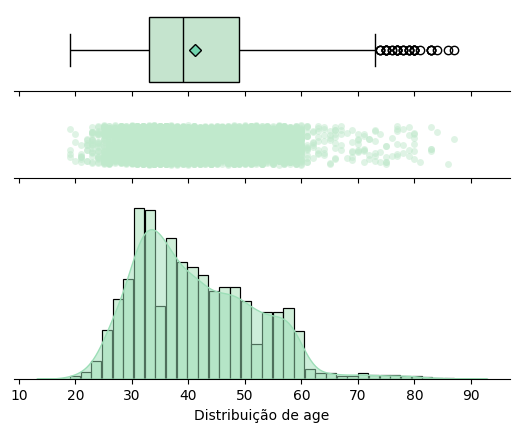

*************************** Resumo Estatístico **************************

A variável age possui 4521 registros.

--- Medidas Tendencia Central -------------------------------------------
     Média Mediana
age  41.17   39.00

--- Medidas de Dispersão ------------------------------------------------
        dp     var    CV%  Skew    min    max Alcance
age  10.58  111.86  25.69  0.70  19.00  87.00   68.00

--- Medidas Separatrizes ------------------------------------------------
     Q1(25%)  Q2(50%)  Q3(75%)  Limite inferior  Limite Superior
age     33.0     39.0     49.0              9.0             73.0

----- Teste de Normalidade dos dados (Shapiro) -----
H₀ - Hipótese Nula: Os dados seguem uma distribuição normal.
H₁ - Hipótese Alternativa: Os dados não seguem uma distribuição normal.
p_valor: 9.427573604575e-34 < 0.05. Os dados de age não seguem uma distribuição normal (Hipótese nula rejeitada).


In [30]:
# Distribuição das variáveis numéricas
eda_bank_marketing.plot_distribuicao(coluna='age')
                                   

##### <code style="color:gold"> Variável job </code>

In [32]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='job')

,job,frequencia,porcentagem
11,unknown,38,0.840522
10,student,84,1.857996
9,housemaid,112,2.477328
8,unemployed,128,2.831232
7,entrepreneur,168,3.715992
6,self-employed,183,4.047777
5,retired,230,5.087370
4,services,417,9.223623
3,admin.,478,10.572882
2,technician,768,16.987392


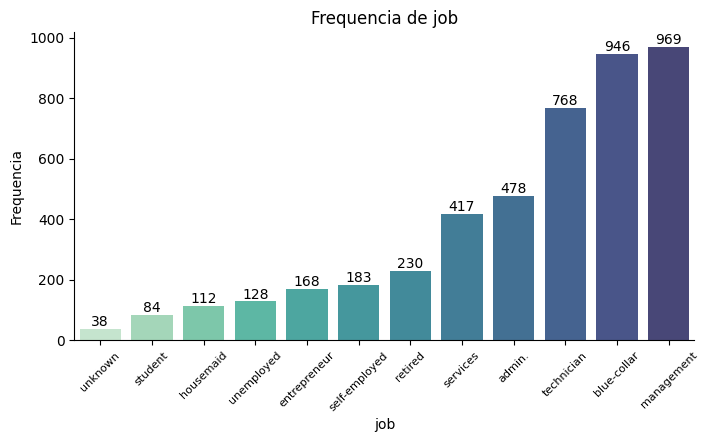

In [31]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='job')

##### <code style="color:gold"> Variável marital </code>

In [35]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='marital')

,marital,frequencia,porcentagem
2,divorced,528,11.678832
1,single,1196,26.454324
0,married,2797,61.866844


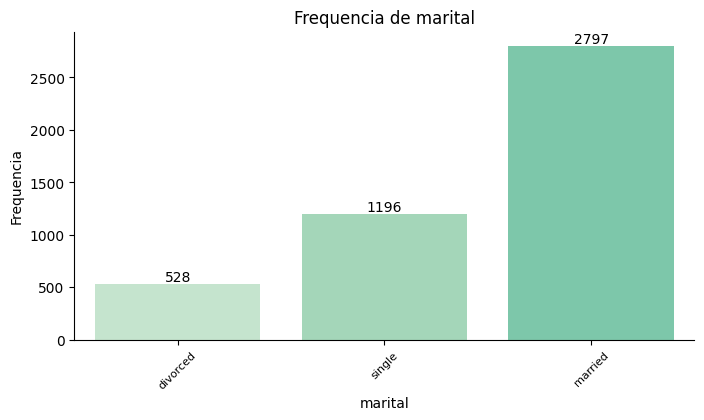

In [36]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='marital')

##### <code style="color:gold"> Variável education </code>

In [37]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='education')

,education,frequencia,porcentagem
3,unknown,187,4.136253
2,primary,678,14.996682
1,tertiary,1350,29.860650
0,secondary,2306,51.006415


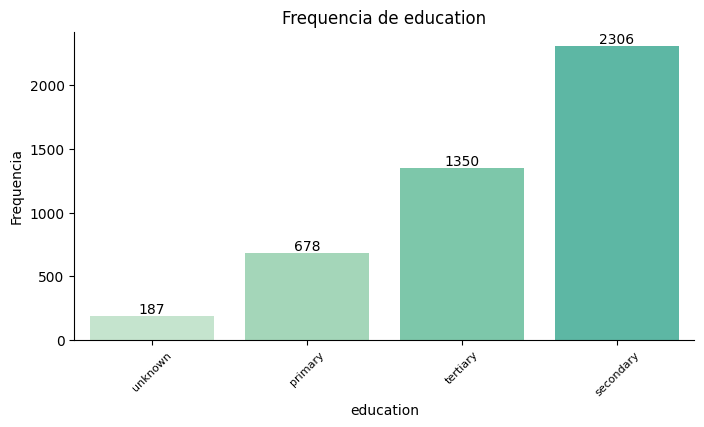

In [38]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='education')

##### <code style="color:gold"> Variável default </code>

In [39]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='default')

,default,frequencia,porcentagem
1,yes,76,1.681044
0,no,4445,98.318956


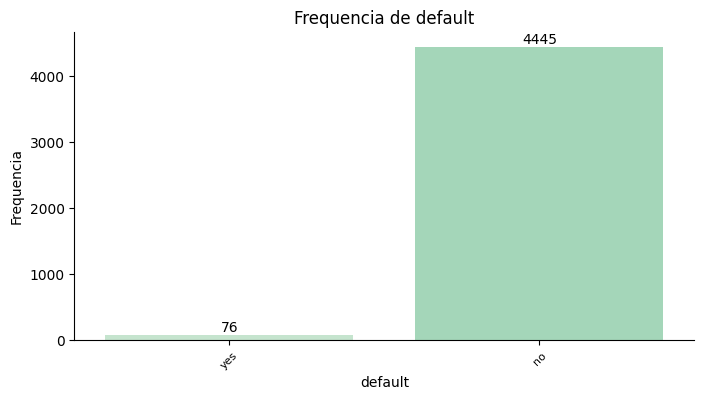

In [40]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='default')

##### <code style="color:gold"> Variável balance </code>

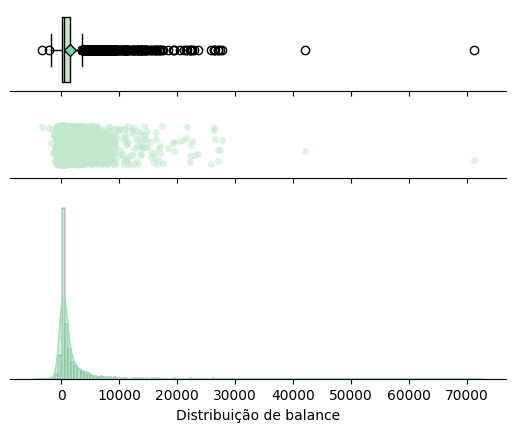

*************************** Resumo Estatístico **************************

A variável balance possui 4521 registros.

--- Medidas Tendencia Central -------------------------------------------
           Média Mediana
balance  1422.66  444.00

--- Medidas de Dispersão ------------------------------------------------
              dp         var     CV%  Skew       min       max   Alcance
balance  3009.64  9057921.75  211.55  6.60  -3313.00  71188.00  74501.00

--- Medidas Separatrizes ------------------------------------------------
         Q1(25%)  Q2(50%)  Q3(75%)  Limite inferior  Limite Superior
balance     69.0    444.0   1480.0          -2047.5           3596.5

----- Teste de Normalidade dos dados (Shapiro) -----
H₀ - Hipótese Nula: Os dados seguem uma distribuição normal.
H₁ - Hipótese Alternativa: Os dados não seguem uma distribuição normal.
p_valor: 1.124061228956861e-77 < 0.05. Os dados de balance não seguem uma distribuição normal (Hipótese nula rejeitada).


In [41]:
# Distribuição das variáveis numéricas
eda_bank_marketing.plot_distribuicao(coluna='balance')

##### <code style="color:gold"> Variável housing  </code>

In [42]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='housing')

,housing,frequencia,porcentagem
1,no,1962,43.397478
0,yes,2559,56.602522


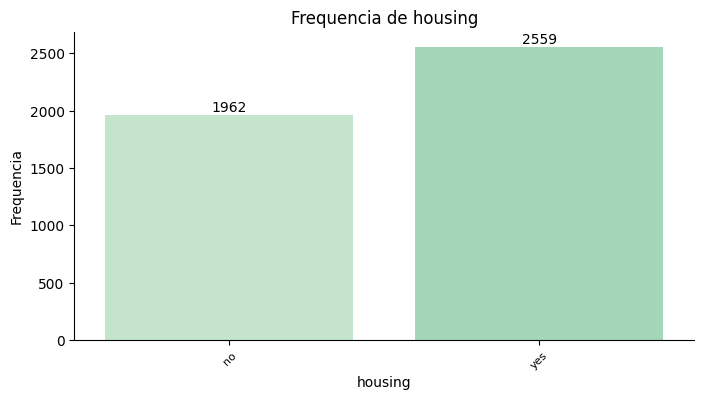

In [43]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='housing')

##### <code style="color:gold"> Variável loan  </code>

In [44]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='loan')

,loan,frequencia,porcentagem
1,yes,691,15.284229
0,no,3830,84.715771


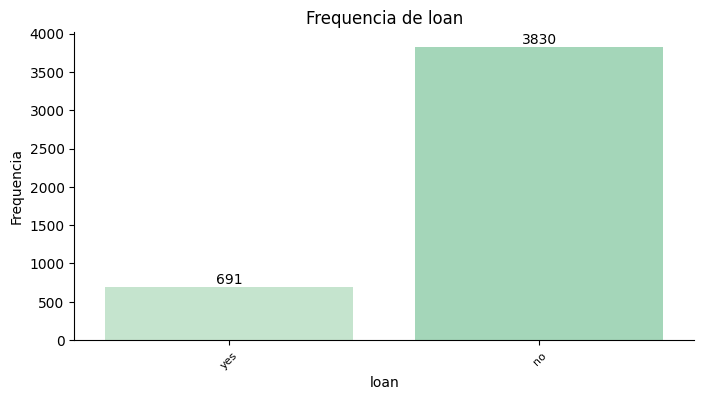

In [45]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='loan')

##### <code style="color:gold"> Variável contact  </code>

In [46]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='contact')

,contact,frequencia,porcentagem
2,telephone,301,6.657819
1,unknown,1324,29.285556
0,cellular,2896,64.056625


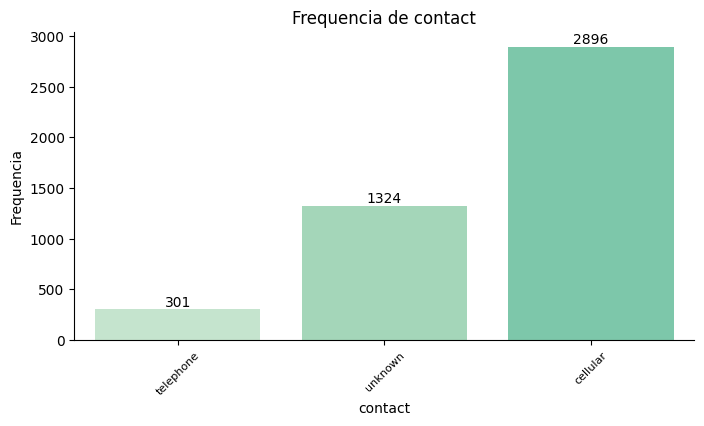

In [47]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='contact')

##### <code style="color:gold"> Variável day  </code>

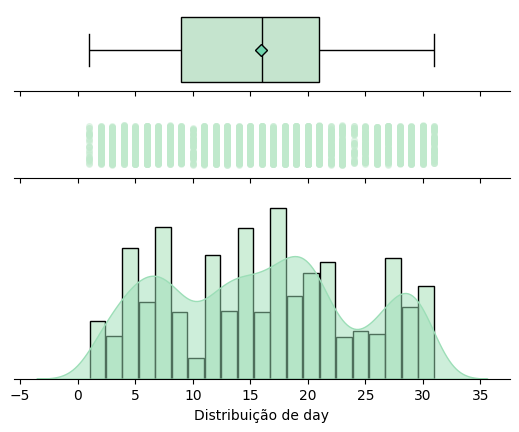

*************************** Resumo Estatístico **************************

A variável day possui 4521 registros.

--- Medidas Tendencia Central -------------------------------------------
     Média Mediana
day  15.92   16.00

--- Medidas de Dispersão ------------------------------------------------
       dp    var    CV%  Skew   min    max Alcance
day  8.25  68.02  51.82  0.09  1.00  31.00   30.00

--- Medidas Separatrizes ------------------------------------------------
     Q1(25%)  Q2(50%)  Q3(75%)  Limite inferior  Limite Superior
day      9.0     16.0     21.0             -9.0             39.0

----- Teste de Normalidade dos dados (Shapiro) -----
H₀ - Hipótese Nula: Os dados seguem uma distribuição normal.
H₁ - Hipótese Alternativa: Os dados não seguem uma distribuição normal.
p_valor: 2.459438015845874e-33 < 0.05. Os dados de day não seguem uma distribuição normal (Hipótese nula rejeitada).


In [48]:
# Distribuição das variáveis numéricas
eda_bank_marketing.plot_distribuicao(coluna='day')

##### <code style="color:gold"> Variável month </code>

In [52]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='month')

,month,frequencia,porcentagem
11,dec,20,0.442380
10,mar,49,1.083831
9,sep,52,1.150188
8,oct,80,1.769520
7,jan,148,3.273612
6,feb,222,4.910418
5,apr,293,6.480867
4,nov,389,8.604291
3,jun,531,11.745189
2,aug,633,14.001327


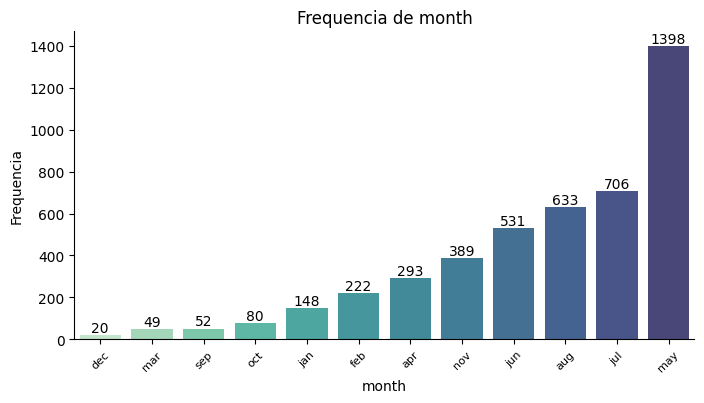

In [53]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='month')

##### <code style="color:gold"> Variável duration </code>

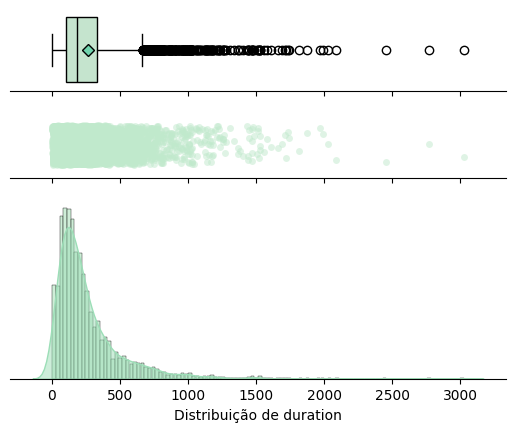

*************************** Resumo Estatístico **************************

A variável duration possui 4521 registros.

--- Medidas Tendencia Central -------------------------------------------
           Média Mediana
duration  263.96  185.00

--- Medidas de Dispersão ------------------------------------------------
              dp       var    CV%  Skew   min      max  Alcance
duration  259.86  67525.47  98.44  2.77  4.00  3025.00  3021.00

--- Medidas Separatrizes ------------------------------------------------
          Q1(25%)  Q2(50%)  Q3(75%)  Limite inferior  Limite Superior
duration    104.0    185.0    329.0           -233.5            666.5

----- Teste de Normalidade dos dados (Shapiro) -----
H₀ - Hipótese Nula: Os dados seguem uma distribuição normal.
H₁ - Hipótese Alternativa: Os dados não seguem uma distribuição normal.
p_valor: 6.241177661046895e-64 < 0.05. Os dados de duration não seguem uma distribuição normal (Hipótese nula rejeitada).


In [272]:
eda_bank_marketing.plot_distribuicao(coluna='duration')

##### <code style="color:gold"> Variável campaign </code>

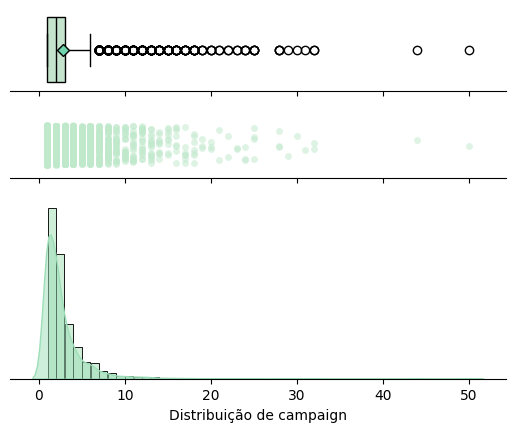

*************************** Resumo Estatístico **************************

A variável campaign possui 4521 registros.

--- Medidas Tendencia Central -------------------------------------------
         Média Mediana
campaign  2.79    2.00

--- Medidas de Dispersão ------------------------------------------------
            dp   var     CV%  Skew   min    max Alcance
campaign  3.11  9.67  111.32  4.74  1.00  50.00   49.00

--- Medidas Separatrizes ------------------------------------------------
          Q1(25%)  Q2(50%)  Q3(75%)  Limite inferior  Limite Superior
campaign      1.0      2.0      3.0             -2.0              6.0

----- Teste de Normalidade dos dados (Shapiro) -----
H₀ - Hipótese Nula: Os dados seguem uma distribuição normal.
H₁ - Hipótese Alternativa: Os dados não seguem uma distribuição normal.
p_valor: 5.174549847036246e-75 < 0.05. Os dados de campaign não seguem uma distribuição normal (Hipótese nula rejeitada).


In [54]:
# Distribuição das variáveis numéricas
eda_bank_marketing.plot_distribuicao(coluna='campaign')

##### <code style="color:gold"> Variável pdays  </code>

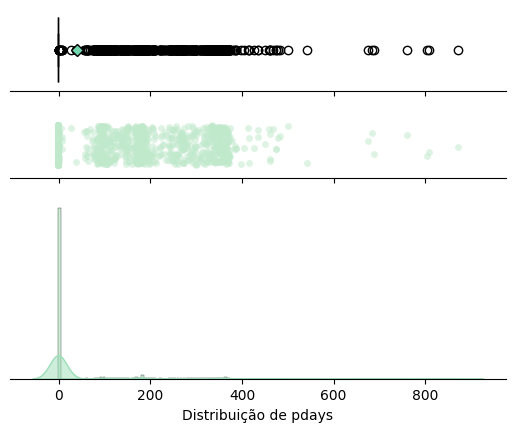

*************************** Resumo Estatístico **************************

A variável pdays possui 4521 registros.

--- Medidas Tendencia Central -------------------------------------------
       Média Mediana
pdays  39.77   -1.00

--- Medidas de Dispersão ------------------------------------------------
           dp       var     CV%  Skew    min     max Alcance
pdays  100.12  10024.24  251.77  2.72  -1.00  871.00  872.00

--- Medidas Separatrizes ------------------------------------------------
       Q1(25%)  Q2(50%)  Q3(75%)  Limite inferior  Limite Superior
pdays     -1.0     -1.0     -1.0             -1.0             -1.0

----- Teste de Normalidade dos dados (Shapiro) -----
H₀ - Hipótese Nula: Os dados seguem uma distribuição normal.
H₁ - Hipótese Alternativa: Os dados não seguem uma distribuição normal.
p_valor: 5.779153971271526e-79 < 0.05. Os dados de pdays não seguem uma distribuição normal (Hipótese nula rejeitada).


In [55]:
# Distribuição das variáveis numéricas
eda_bank_marketing.plot_distribuicao(coluna='pdays')

##### <code style="color:gold"> Variável previous  </code>

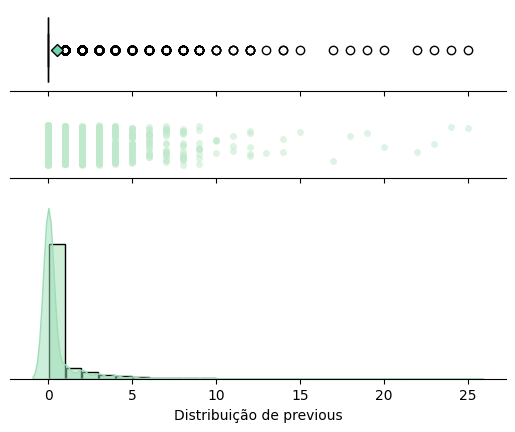

*************************** Resumo Estatístico **************************

A variável previous possui 4521 registros.

--- Medidas Tendencia Central -------------------------------------------
         Média Mediana
previous  0.54    0.00

--- Medidas de Dispersão ------------------------------------------------
            dp   var     CV%  Skew   min    max Alcance
previous  1.69  2.87  312.13  5.88  0.00  25.00   25.00

--- Medidas Separatrizes ------------------------------------------------
          Q1(25%)  Q2(50%)  Q3(75%)  Limite inferior  Limite Superior
previous      0.0      0.0      0.0              0.0              0.0

----- Teste de Normalidade dos dados (Shapiro) -----
H₀ - Hipótese Nula: Os dados seguem uma distribuição normal.
H₁ - Hipótese Alternativa: Os dados não seguem uma distribuição normal.
p_valor: 4.543066320674062e-83 < 0.05. Os dados de previous não seguem uma distribuição normal (Hipótese nula rejeitada).


In [56]:
# Distribuição das variáveis numéricas
eda_bank_marketing.plot_distribuicao(coluna='previous')

##### <code style="color:gold"> Variável poutcome  </code>

In [57]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='poutcome')

,poutcome,frequencia,porcentagem
3,success,129,2.853351
2,other,197,4.357443
1,failure,490,10.838310
0,unknown,3705,81.950896


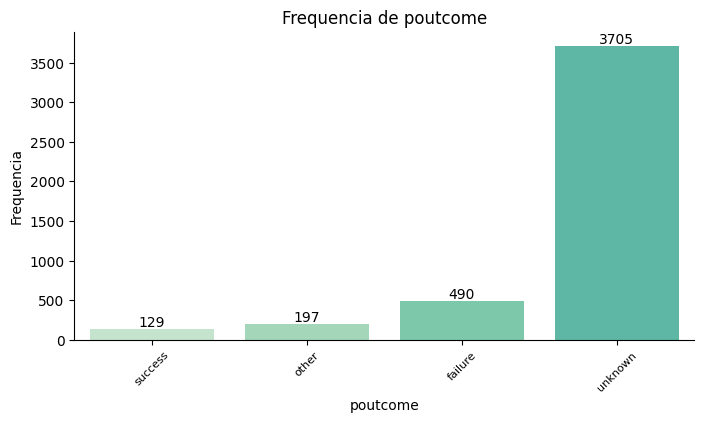

In [58]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='poutcome')

##### <code style="color:gold"> Variável y (target)  </code>

In [59]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='y')

,y,frequencia,porcentagem
1,yes,521,11.523999
0,no,4000,88.476001


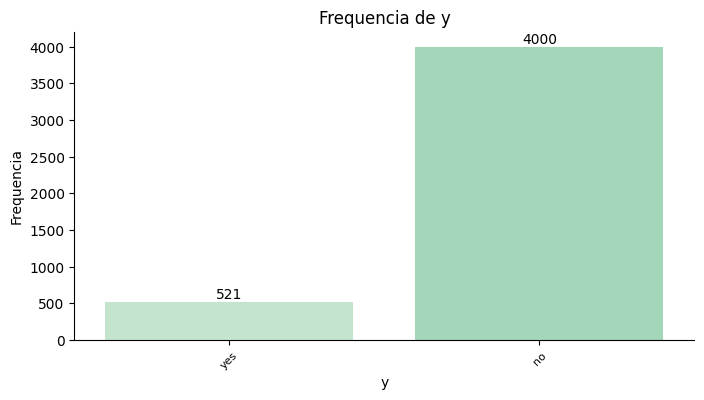

In [60]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='y')

### <code style="color:green"> Conclusões da EDA Univariada </code>

<code style="color:gold"> Insights age </code>
 - A média de idade é de aproximadamente 41.17 anos.
 - A idade dos clientes varia entre 19 a 87 anos.
 - A maioria dos clientes esta entre 33 e 49 anos.
 - Possui assimetria a direita, com variação de 25.69% dos dados em relação a média.
 - Possui outliers.
 - Os dados de age não seguem uma distribuição normal.
 
<code style="color:gold"> Insights job </code>
 - Possui 12 grupos.
 - O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.
 - A maioria dos clientes trabalha como management, com 21.43% dos casos.
 
<code style="color:gold"> Insights marital </code>
 - Possui 3 grupos.
 - Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).
 - A maioria dos clientes é casada, com 61.87% dos casos.
 
<code style="color:gold"> Insights education </code>
 - Possui 4 grupos.
 - Os grupos estão desbalanceados. O grupo unknown possui um volume de dados abaixo de 300 registros.
 - A maioria dos clientes tem o grau de educação secondary, com 51% dos casos.
 
<code style="color:gold"> Insights default </code>
 - Possui 2 grupos.
 - Os grupos estão desbalanceados, sendo que grupo yes possui um volume de dados abaixo de 300 registros.
 - A maioria dos clientes não tem crédito em default, com 98.32% dos casos.

<code style="color:gold"> Insights balance </code>
 - A média do saldo médio anual é de aproximadamente 1422.66 euros.
 - O saldo médio anual varia entre -3313.00 a 71188.00 euros.
 - A maioria dos saldos médios anuais esta entre 69.0 e 444.0 anos.
 - Possui forte assimetria a direita, com variação de 211.55% dos dados em relação a média.
 - Possui outliers.
 - Os dados de balance não seguem uma distribuição normal.

<code style="color:gold"> Insights housing </code>
 - Possui 2 grupos.
 - Os grupos possuem um volume de dados adequado (> 300 registros).
 - A maioria dos clientes tem empréstimo habitacional, com 56.60% dos casos.

<code style="color:gold"> Insights loan </code>
 - Possui 2 grupos.
 - Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).
 - A maioria dos clientes não tem empréstimo pessoal, com 84.72% dos casos.

<code style="color:gold"> Insights contact </code>
 - Possui 3 grupos.
 - Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).
 - A maioria dos clientes foram contatados através do celular, com 64.05% dos casos.

<code style="color:gold"> Insights day </code>
 - Na média, o ultimo dia de contato no mês é aproximadamente dia 16.
 - O ultimo dia de contato no mês varia entre 1 a 31.
 - A maioria do ultimo dia de contato no mês esta entre 9 e 21.
 - Não possui outliers.
 - Os dados de day não seguem uma distribuição normal.

<code style="color:gold"> Insights month </code>
 - Possui 12 grupos.
 - O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.
 - A maioria do ultimo mês de contato do ano foi em maio, com 30.92% dos casos.

<code style="color:gold"> Insights duration </code>
 - A média de duração do último contato foi de aproximadamente 263.96 segundos.
 - A duração do último contato varia de 4 a 3025 segundos.
 - A maioria da duração do último contato esta entre 104 e 329 segundos.
 - Possui forte assimetria a direita, com variação dos dados em relação a média de 98.44%.
 - Possui outliers.
 - Os dados de duration não seguem uma distribuição normal.

<code style="color:gold"> Insights campaign </code>
 - A média do número de contatos realizados durante esta campanha é de aproximadamente dia 2.79.
 - O número de contatos realizados durante esta campanha varia entre 1 a 50.
 - A maioria de contatos realizados durante esta campanha esta entre 1 e 3.
 - Possui forte assimetria a direita, com variação dos dados em relação a média de 111.32%.
 - Possui outliers.
 - Os dados de campaign não seguem uma distribuição normal.

<code style="color:gold"> Insights pdays </code>
 - A média do número de dias que se passaram desde que o cliente foi contatado pela última vez em uma campanha anterior é de aproximadamente 40 dias.
 - O número de dias que se passaram desde que o cliente foi contatado pela última vez em uma campanha anterior varia entre -1 a 871 dias.
 - A maioria do número de dias que se passaram desde que o cliente foi contatado pela última vez em uma campanha anterior é -1. Isto significa que o cliente não foi contatado anteriormente.
 - Possui forte assimetria a direita, com variação dos dados em relação a média de 251.77%.
 - Possui outliers.
 - Os dados de pdays não seguem uma distribuição normal.

<code style="color:gold"> Insights previous </code>
 - A média do número de contatos realizados antes desta campanha é de aproximadamente 0.54.
 - O número de contatos realizados antes desta campanha varia entre 0 a 25.
 - A maioria do número de contatos realizados antes desta campanha é 0.
 - Possui forte assimetria a direita, com variação dos dados em relação a média de 312.13%.
 - Possui outliers.
 - Os dados de previous não seguem uma distribuição normal.

<code style="color:gold"> Insights poutcome </code>
 - Possui 4 grupos.
 - O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.
 - A maioria do resultado da campanha de marketing anterior é unknown, com 81.95% dos casos.

<code style="color:gold"> Insights y (target) </code>
 - Possui 2 grupos.
 - O volume de dados entre os grupos é desbalanceado 12% para assinou um depósito a prazo e 88% para `não` assinou um depósito a prazo. Por se tratar da variável do objetivo desejado, este desbalanceamento, precisa de atenção.
 - Será necessario realizar um tratamento nos dados, convertendo yes=1 e no=0.


### <code style="color:green"> Vamos atualizar nosso Dicionário de dados </code>

- <code style="color:gold"> Dados do cliente </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| age    | numérico | Idade do cliente   |Possui assimetria a direita, com variação de 25.69% dos dados em relação a média. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de age não seguem uma distribuição normal. |
| job    | categórico | Tipo de trabalho |Possui 12 grupos. | 
|        |          |                    |O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros. |
|        |          |                    |A maioria dos clientes trabalha como management, com 21.43% dos casos. |
|        |          |                    | Será necessário um tratamento na nomenclatura do grupos. |
| marital   | categórico| Estado civil | Possui 3 grupos.|
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes é casada, com 61.87% dos casos. |
| education    | categórico| Educação |Possui 4 grupos. |
|        |          |                    |Os grupos estão desbalanceados. O grupo unknown possui um volume de dados abaixo de 300 registros.|
|        |          |                    |A maioria dos clientes tem o grau de educação secondary, com 51% dos casos. |

- <code style="color:gold"> Dados bancários </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| default | binário: "yes","no" | tem crédito em default? | Possui 2 grupos. |
|        |          |                    |Os grupos estão desbalanceados, sendo que grupo yes possui um volume de dados abaixo de 300 registros.|
|        |          |                    |A maioria dos clientes não tem crédito em default, com 98.32% dos casos.|
| balance | numérico | saldo médio anual, em euros |Possui forte assimetria a direita, com variação de 211.55% dos dados em relação a média. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de balance não seguem uma distribuição normal. |
| housing | binário: "yes","no" | tem empréstimo habitacional? | Possui 2 grupos. |
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes tem empréstimo habitacional, com 56.60% dos casos.|
| loan | binário: "yes","no" | tem empréstimo pessoal? |Possui 2 grupos. |
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes não tem empréstimo pessoal, com 84.72% dos casos.|

- <code style="color:gold"> Dados relacionados com o ultimo contato da campanha atual </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| contact | categórico | tipo de comunicação do contato | Possui 3 grupos.|
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes foram contatados através do celular, com 64.05% dos casos.|
| day | numérico |  último dia de contato do mês | Não possui outliers.|
|     |          |                               | Os dados de day não seguem uma distribuição normal.|
| month | categórico | último mês de contato do ano |Possui 12 grupos. |
|        |          |                    |O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.|
|        |          |                    |A maioria do ultimo mês de contato do ano foi em maio, com 30.92% dos casos.|
| duration | numérico | duração do último contato, em segundos | Possui forte assimetria a direita, com variação dos dados em relação a média de 98.44%.|
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de duration não seguem uma distribuição normal. |
| campaign | numérico | número de contatos realizados durante esta campanha e para este cliente <br> (inclui o último contato) |Possui forte assimetria a direita, com variação dos dados em relação a média de 111.32%. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de campaign não seguem uma distribuição normal. |
| pdays | numérico | número de dias que se passaram desde que o cliente foi contatado pela última vez <br> em uma campanha anterior (-1 significa que o cliente não foi contatado anteriormente) |Possui forte assimetria a direita, com variação dos dados em relação a média de 251.77%. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de campaign não seguem uma distribuição normal. |
| previous | numérico | número de contatos realizados antes desta campanha e para este cliente | Possui forte assimetria a direita, com variação dos dados em relação a média de 312.13%. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de campaign não seguem uma distribuição normal. |
| poutcome | categórico | resultado da campanha de marketing anterior | Possui 4 grupos.|
|        |          |                    |O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.|
|        |          |                    |A maioria do resultado da campanha de marketing anterior é unknown, com 81.95% dos casos.|

- <code style="color:gold"> Variável target (objetivo) </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| y | binário: "yes","no" | o cliente assinou um depósito a prazo? | Possui 2 grupos.|
|        |          |                    |O volume de dados entre os grupos é desbalanceado 12% para assinou um depósito a prazo e 88% para `não` assinou um depósito a prazo. <br> Por se tratar da variável do objetivo desejado, este desbalanceamento, precisa de atenção.|
|        |          |                    |Será necessario realizar um tratamento nos dados, convertendo yes=1 e no=0.|



<code style="color:gold"> Referência: </code>

  This dataset is public available for research. The details are described in [Moro et al., 2011]. 

  Please include this citation if you plan to use this database:

  [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

### <code style="color:green">EDA - Análise exploratória Bivariada </code>

##### <code style="color:gold"> Verificando a multicolinearidade entre as variáveis independentes numéricas  </code>

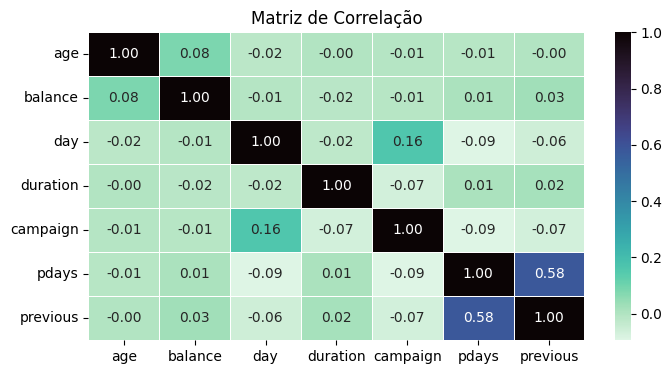

Utilizando o threshold (corte): 0.7, não foram encontrados casos de multicolinearidade.



In [107]:
# Testando a correlação de Pearson
eda_bank_marketing.pearson_corr(target="y", threshold=0.7)

### <code style="color:green"> Verificando a relação linear entre as variáveis independentes numéricas e a variável y (target)  </code>

#### <code style="color:gold"> Será necessario realizar um tratamento nos dados da variável y, convertendo yes=1 e no=0. </code>
 - Vou criar outra variavel chamada subscribed para armazenar essa modificação.

In [575]:
# Convertendo yes=1 e no=0 nos dados da variavel y
df_bank_marketing['subscribed'] = np.where(df_bank_marketing['y'] == 'yes', 1, 0)

##### <code style="color:gold"> Variável age e subscribed (target)  </code>

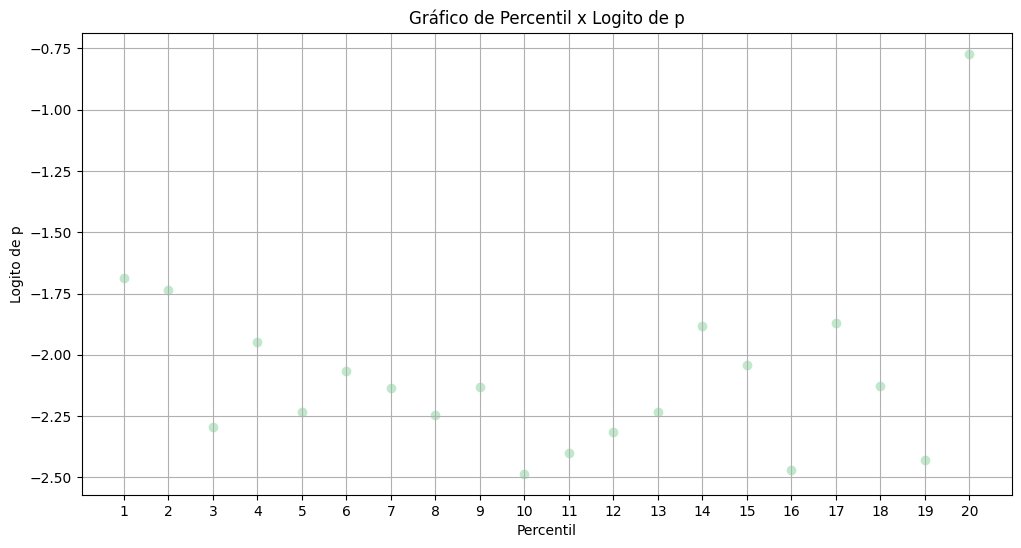

,percentil,n,min_x,max_x,p,logito_p
0,1,282,19,27,0.156028,-1.688081
1,2,200,28,29,0.150000,-1.734601
2,3,349,30,31,0.091691,-2.293166
3,4,224,32,32,0.125000,-1.945910
4,5,186,33,33,0.096774,-2.233592
5,6,231,34,34,0.112554,-2.064913
6,7,180,35,35,0.105556,-2.136965
7,8,188,36,36,0.095745,-2.245427
8,9,320,37,38,0.106250,-2.129631
9,10,130,39,39,0.076923,-2.484907


In [269]:
rl.analise_var_numerica_por_percentil(data=df_bank_marketing, x='age', y='subscribed', q=20, grafico='logito')

<code style="color:gold"> Através do gráfico não consigo identificar uma relação linear entre `age` e `subscribed`. </code>

 Será necessário categorizar a variável `age`.

In [576]:
# Categorizando a variável age
df_bank_marketing['age_cat'] = pd.cut(df_bank_marketing['age'], bins=[0, 39, 87], labels=['0_39', '40_87']) 

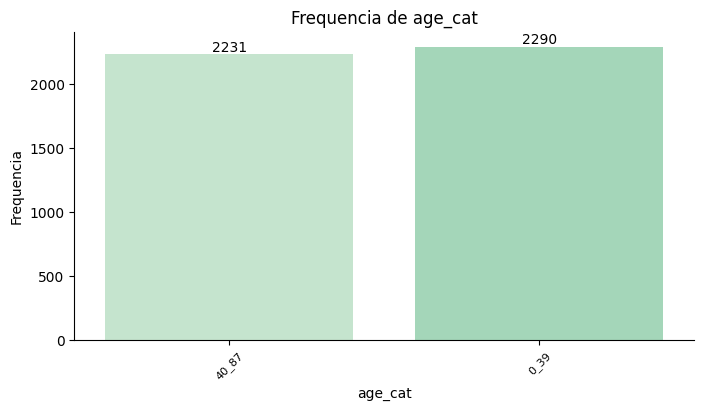

In [452]:
eda_bank_marketing.plot_frequencia_cat(coluna='age_cat')

##### <code style="color:gold"> Variável balance e subscribed (target)  </code>

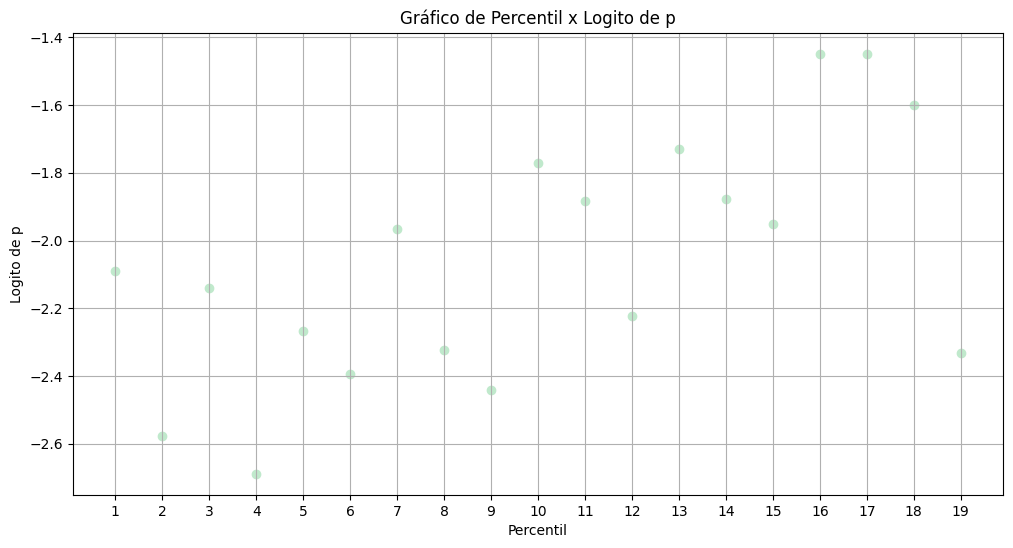

,percentil,n,min_x,max_x,p,logito_p
0,1,227,-3313,-162,0.110132,-2.089392
1,2,496,-154,0,0.070565,-2.578050
2,3,190,1,23,0.105263,-2.140066
3,4,220,24,69,0.063636,-2.688819
4,5,224,70,128,0.093750,-2.268684
5,6,227,130,194,0.083700,-2.393099
6,7,228,195,263,0.122807,-1.966113
7,8,224,264,351,0.089286,-2.322388
8,9,225,352,444,0.080000,-2.442347
9,10,227,445,574,0.145374,-1.771351


In [268]:
rl.analise_var_numerica_por_percentil(data=df_bank_marketing, x='balance', y='subscribed', q=20, grafico='logito')

<code style="color:gold"> Através do gráfico consigo identificar uma relação linear entre `balance` e `subscribed`. </code>

##### <code style="color:gold"> Variável day e subscribed (target)  </code>

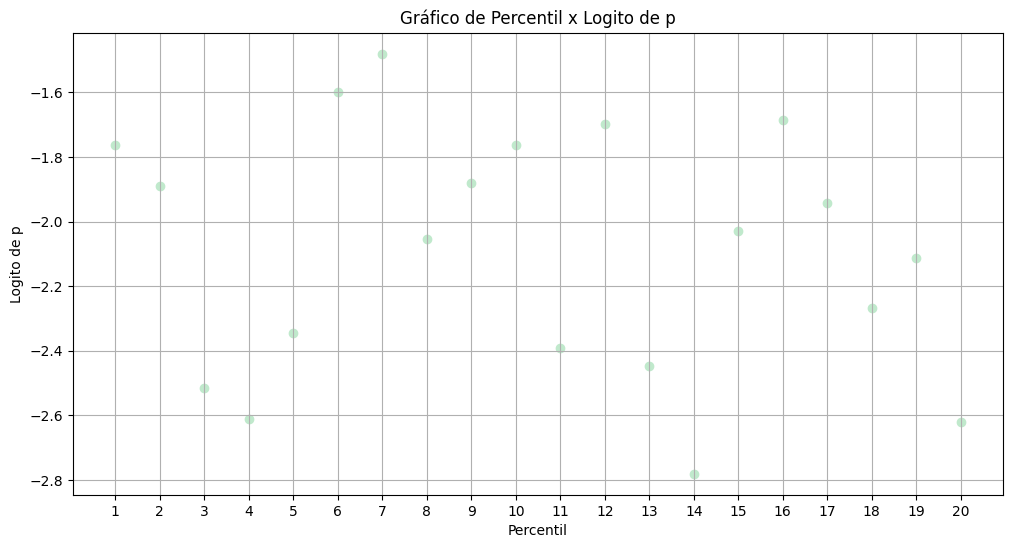

,percentil,n,min_x,max_x,p,logito_p
0,1,246,1,3,0.146341,-1.763589
1,2,320,4,5,0.131250,-1.889951
2,3,187,6,6,0.074866,-2.514234
3,4,190,7,7,0.068421,-2.611200
4,5,343,8,9,0.087464,-2.345006
5,6,202,10,11,0.168317,-1.597603
6,7,151,12,12,0.185430,-1.479980
7,8,361,13,14,0.113573,-2.054749
8,9,174,15,15,0.132184,-1.881786
9,10,164,16,16,0.146341,-1.763589


In [267]:
rl.analise_var_numerica_por_percentil(data=df_bank_marketing, x='day', y='subscribed', q=20, grafico='logito')

<code style="color:gold"> Através do gráfico não consigo identificar uma relação linear entre `day` e `subscribed`. </code>

 Será necessário categorizar a variável `day`.

In [577]:
# Categorizando a variável day
df_bank_marketing['day_cat'] = pd.cut(df_bank_marketing['day'], bins=[0, 12, 21, 31], labels=['1_12', '13_21', '22_31'])


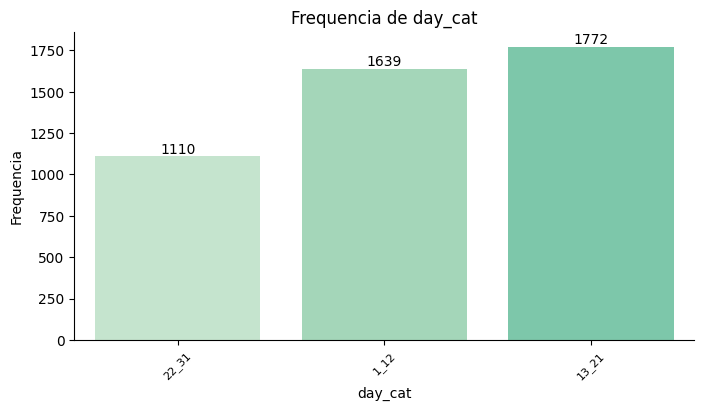

In [453]:
eda_bank_marketing.plot_frequencia_cat(coluna='day_cat')

##### <code style="color:gold"> Variável duration e subscribed (target)  </code>

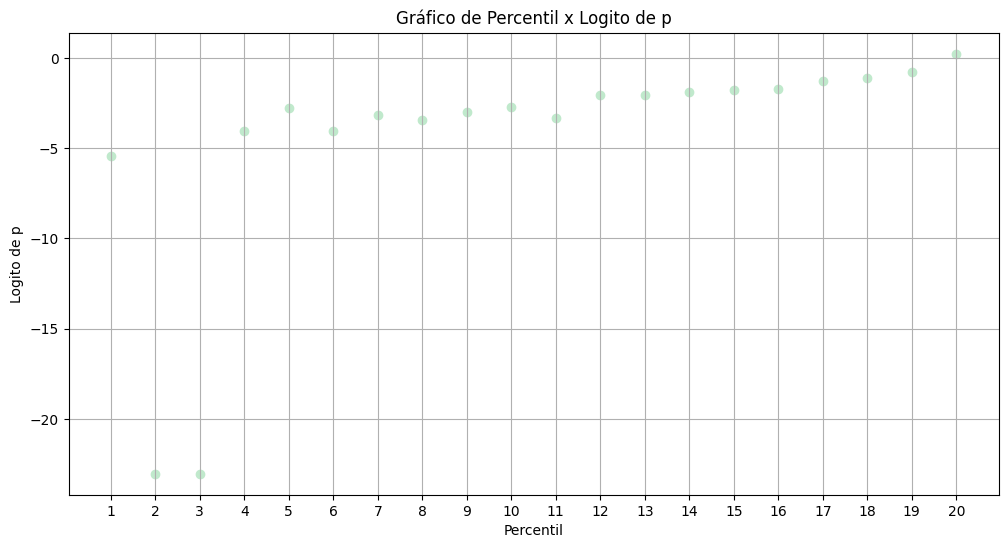

,percentil,n,min_x,max_x,p,logito_p
0,1,231,4,31,0.004329,-5.438079
1,2,237,32,58,0.000000,-23.025851
2,3,214,59,74,0.000000,-23.025851
3,4,235,75,89,0.017021,-4.056123
4,5,222,90,104,0.058559,-2.777385
5,6,232,105,119,0.017241,-4.043051
6,7,225,120,134,0.040000,-3.178054
7,8,221,135,149,0.031674,-3.420066
8,9,227,150,166,0.048458,-2.977383
9,10,224,167,185,0.062500,-2.708050


In [270]:
rl.analise_var_numerica_por_percentil(data=df_bank_marketing, x='duration', y='subscribed', q=20, grafico='logito')

<code style="color:gold"> Através do gráfico consigo identificar uma relação linear entre `duration` e `subscribed`. </code>

##### <code style="color:gold"> Variável campaign e subscribed (target)  </code>

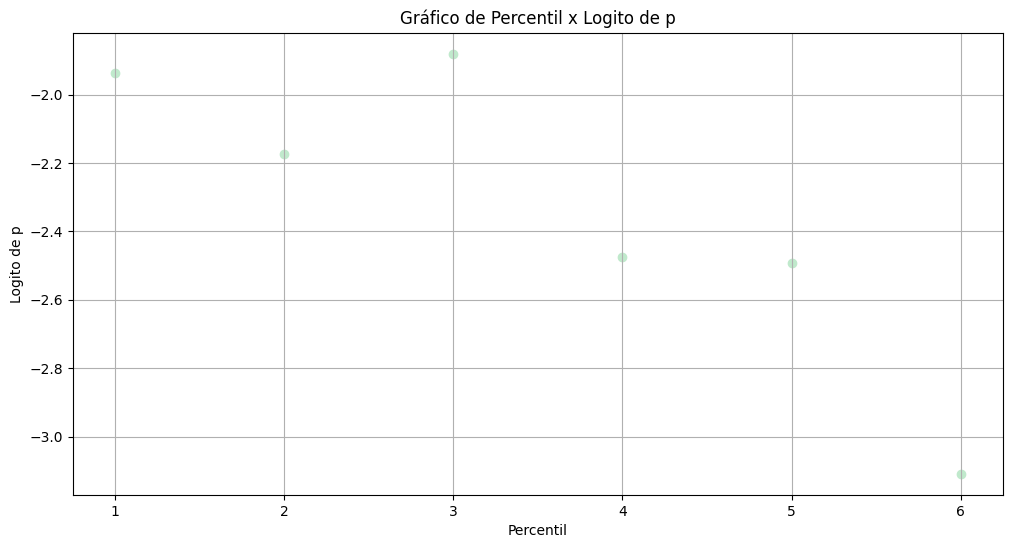

,percentil,n,min_x,max_x,p,logito_p
0,1,2998,1,2,0.126084,-1.936035
1,2,558,3,3,0.102151,-2.173555
2,3,325,4,4,0.132308,-1.880707
3,4,322,5,6,0.077640,-2.474856
4,5,131,7,8,0.076336,-2.493205
5,6,187,9,50,0.042781,-3.107944


In [271]:
rl.analise_var_numerica_por_percentil(data=df_bank_marketing, x='campaign', y='subscribed', q=20, grafico='logito')

<code style="color:gold"> Através do gráfico consigo identificar uma relação linear entre `campaign` e `subscribed`. </code>

##### <code style="color:gold"> Variável pdays e subscribed (target)  </code>

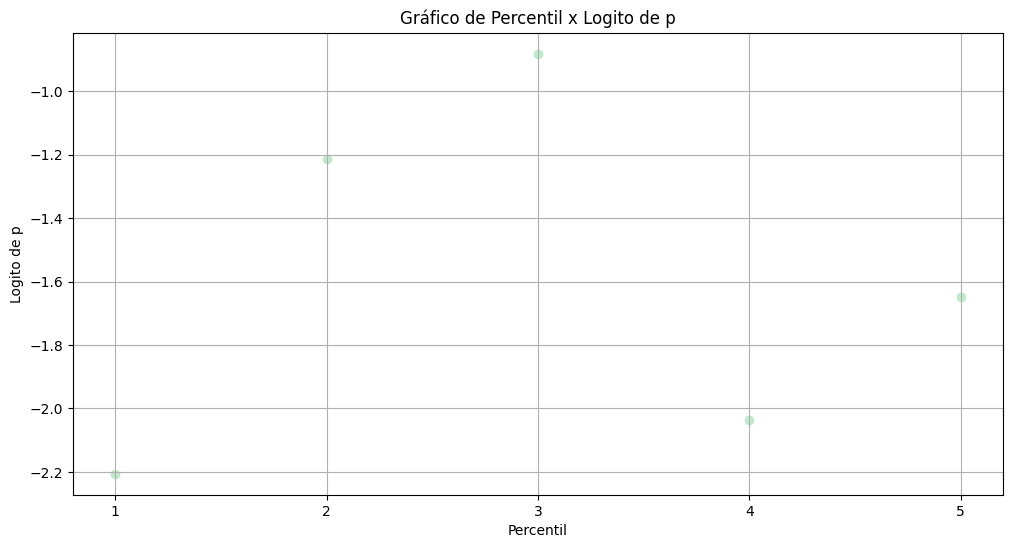

,percentil,n,min_x,max_x,p,logito_p
0,1,3799,-1,92,0.099237,-2.205735
1,2,179,93,168,0.229050,-1.213682
2,3,181,169,222,0.292818,-0.881738
3,4,182,223,337,0.115385,-2.036882
4,5,180,338,871,0.161111,-1.649984


In [263]:
rl.analise_var_numerica_por_percentil(data=df_bank_marketing, x='pdays', y='subscribed', q=25, grafico='logito')

<code style="color:gold"> Através do gráfico não consigo identificar uma relação linear entre `pdays` e `subscribed`. </code>

 Será necessário categorizar a variável `pdays`.

In [578]:
# Categorizando a variável pdays
df_bank_marketing['pdays_cat'] = pd.cut(df_bank_marketing['pdays'], bins=[-2, 92, 871], labels=['sem_contato_92', '93_871'])   

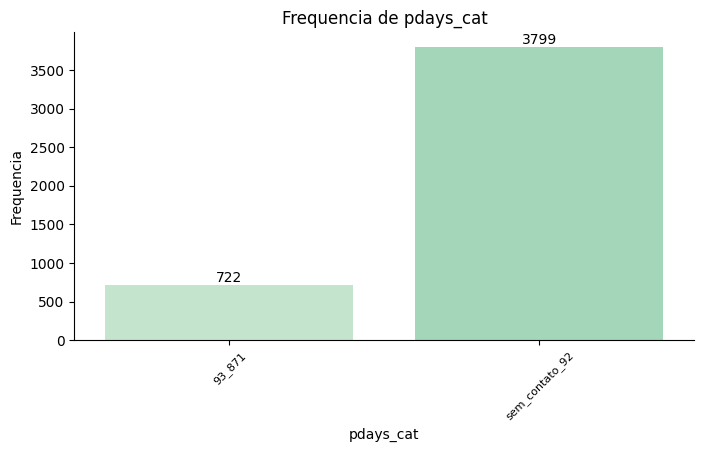

In [579]:
eda_bank_marketing.plot_frequencia_cat(coluna='pdays_cat')

##### <code style="color:gold"> Variável previous e subscribed (target)  </code>

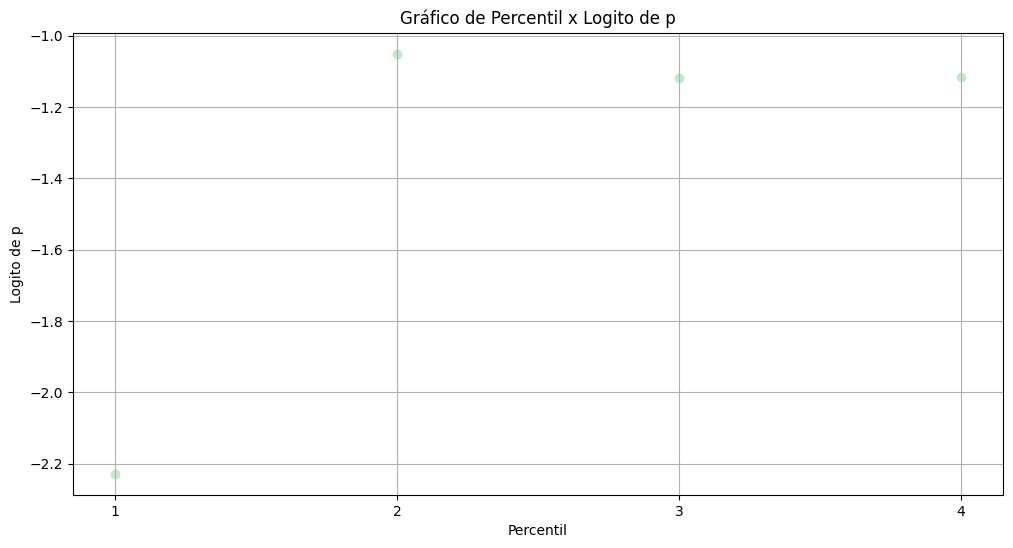

,percentil,n,min_x,max_x,p,logito_p
0,1,3991,0,1,0.097219,-2.228517
1,2,193,2,2,0.259067,-1.050822
2,3,191,3,4,0.246073,-1.119666
3,4,146,5,25,0.246575,-1.116961


In [266]:
rl.analise_var_numerica_por_percentil(data=df_bank_marketing, x='previous', y='subscribed', q=25, grafico='logito')

<code style="color:gold"> Através do gráfico não consigo identificar uma relação linear entre `previous` e `subscribed`. </code>

 Será necessário categorizar a variável `previous`.

In [580]:
# Categorizando a variável previous
df_bank_marketing['previous_cat'] = pd.cut(df_bank_marketing['previous'], bins=[0, 1, 25], labels=['0_1', '2_25'], include_lowest=True)   

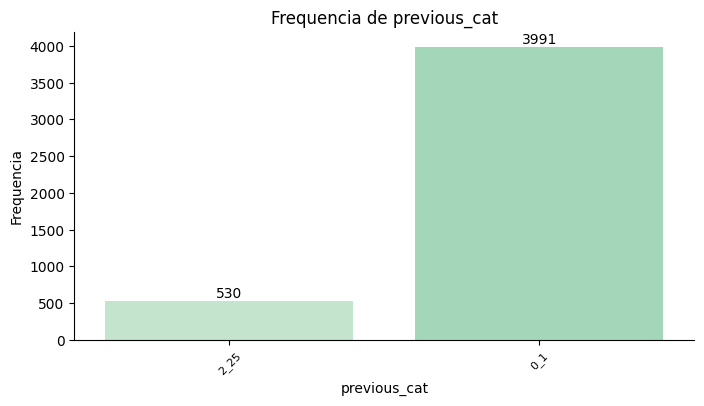

In [581]:
eda_bank_marketing.plot_frequencia_cat(coluna='previous_cat')

<code style="color:gold"> Resumo da análise da relação linear entre as variáveis independentes númericas e `subscribed`. </code>
- As variáveis age, day, pdays e previous foram categorizadas, pois não foi comprovadada a relação linear com a variável subscribed.

### <code style="color:green"> Vamos atualizar nosso Dicionário de dados </code>

- <code style="color:gold"> Dados do cliente </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| age    | numérico | Idade do cliente   |Possui assimetria a direita, com variação de 25.69% dos dados em relação a média. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de age não seguem uma distribuição normal. |
|        |          |                    |Sera categorizada. Não possui uma relação linear com y.|
|        |          |                    | Categorizada em 2 grupos [0-39] e [40-87]|
| job    | categórico | Tipo de trabalho |Possui 12 grupos. | 
|        |          |                    |O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros. |
|        |          |                    |A maioria dos clientes trabalha como management, com 21.43% dos casos. |
|        |          |                    | Será necessário um tratamento na nomenclatura do grupos. |
| marital   | categórico| Estado civil | Possui 3 grupos.|
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes é casada, com 61.87% dos casos. |
| education    | categórico| Educação |Possui 4 grupos. |
|        |          |                    |Os grupos estão desbalanceados. O grupo unknown possui um volume de dados abaixo de 300 registros.|
|        |          |                    |A maioria dos clientes tem o grau de educação secondary, com 51% dos casos. |

- <code style="color:gold"> Dados bancários </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| default | binário: "yes","no" | tem crédito em default? | Possui 2 grupos. |
|        |          |                    |Os grupos estão desbalanceados, sendo que grupo yes possui um volume de dados abaixo de 300 registros.|
|        |          |                    |A maioria dos clientes não tem crédito em default, com 98.32% dos casos.|
| balance | numérico | saldo médio anual, em euros |Possui forte assimetria a direita, com variação de 211.55% dos dados em relação a média. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de balance não seguem uma distribuição normal. |
|        |          |                    |Possui uma relação linear com y.|
| housing | binário: "yes","no" | tem empréstimo habitacional? | Possui 2 grupos. |
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes tem empréstimo habitacional, com 56.60% dos casos.|
| loan | binário: "yes","no" | tem empréstimo pessoal? |Possui 2 grupos. |
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes não tem empréstimo pessoal, com 84.72% dos casos.|

- <code style="color:gold"> Dados relacionados com o ultimo contato da campanha atual </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| contact | categórico | tipo de comunicação do contato | Possui 3 grupos.|
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes foram contatados através do celular, com 64.05% dos casos.|
| day | numérico |  último dia de contato do mês | Não possui outliers.|
|     |          |                               | Os dados de day não seguem uma distribuição normal.|
|        |          |                    |Sera categorizada. Não possui uma relação linear com y.|
|        |          |                    | Categorizada em 3 grupos [1-12], [13-21], e [22-31]|
| month | categórico | último mês de contato do ano |Possui 12 grupos. |
|        |          |                    |O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.|
|        |          |                    |A maioria do ultimo mês de contato do ano foi em maio, com 30.92% dos casos.|
| duration | numérico | duração do último contato, em segundos | Possui forte assimetria a direita, com variação dos dados em relação a média de 98.44%.|
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de duration não seguem uma distribuição normal. |
|        |          |                    |Possui uma relação linear com y.|
| campaign | numérico | número de contatos realizados durante esta campanha e para este cliente <br> (inclui o último contato) |Possui forte assimetria a direita, com variação dos dados em relação a média de 111.32%. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de campaign não seguem uma distribuição normal. |
|        |          |                    |Possui uma relação linear com y.|
| pdays | numérico | número de dias que se passaram desde que o cliente foi contatado pela última vez em uma <br> campanha anterior (-1 significa que o cliente não foi contatado anteriormente) |Possui forte assimetria a direita, com variação dos dados em relação a média de 251.77%. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de campaign não seguem uma distribuição normal. |
|        |          |                    |Sera categorizada. Não possui uma relação linear com y.|
|        |          |                    | Categorizada em 2 grupos [sem_contato-92] e [93-871]|
| previous | numérico | número de contatos realizados antes desta campanha e para este cliente | Possui forte assimetria a direita, com variação dos dados em relação a média de 312.13%. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de campaign não seguem uma distribuição normal. |
|        |          |                    |Sera categorizada. Não possui uma relação linear com y.|
|        |          |                    | Categorizada em 2 grupos [0-1] e [2-25]|
| poutcome | categórico | resultado da campanha de marketing anterior | Possui 4 grupos.|
|        |          |                    |O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.|
|        |          |                    |A maioria do resultado da campanha de marketing anterior é unknown, com 81.95% dos casos.|

- <code style="color:gold"> Variável target (objetivo) </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| y | binário: "yes","no" | o cliente assinou um depósito a prazo? | Possui 2 grupos.|
|        |          |                    |O volume de dados entre os grupos é desbalanceado 12% para assinou um depósito a prazo e 88% para `não` assinou um depósito a prazo.<br> Por se tratar da variável do objetivo desejado, este desbalanceamento, precisa de atenção.|
|        |          |                    |Será necessario realizar um tratamento nos dados, convertendo yes=1 e no=0.|



<code style="color:gold"> Referência: </code>

  This dataset is public available for research. The details are described in [Moro et al., 2011]. 

  Please include this citation if you plan to use this database:

  [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

### <code style="color:green"> Analisando o nível de associação entre as variáveis independentes categóricas e subscribed (target)   </code>

- Vamos utilizar o teste de Hipóteses qui-quadrado e teste V de Cramer.

##### <code style="color:gold"> Variável job e subscribed (target)  </code>

In [15]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='job', target='subscribed')

,job,subscribed,frequencia,porcentagem
0,admin.,0,420,87.866109
1,admin.,1,58,12.133891
2,blue-collar,0,877,92.706131
3,blue-collar,1,69,7.293869
4,entrepreneur,0,153,91.071429
5,entrepreneur,1,15,8.928571
6,housemaid,0,98,87.500000
7,housemaid,1,14,12.500000
8,management,0,838,86.480908
9,management,1,131,13.519092


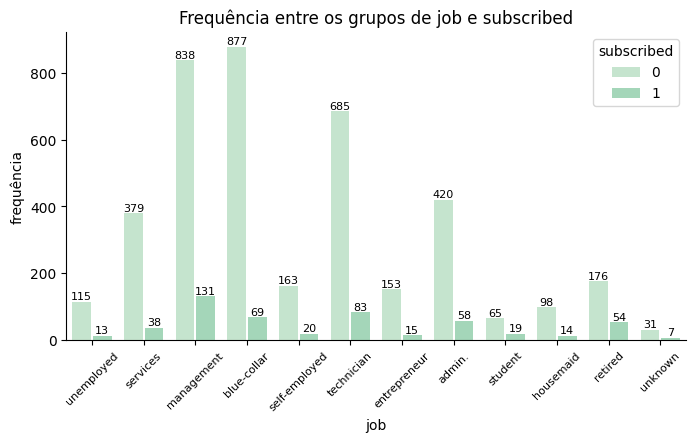

In [41]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='job', target='subscribed', orient='v')

In [25]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='job', var_categorica2='subscribed')


----- Hipóteses -----
H0 : Não existe associação entre as variáveis job e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis job e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 68.98828575267176
P_valor: 1.901391096662705e-10

----- Conclusão -----
- p_valor: 0.0000000002 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis job e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.1235294260


##### <code style="color:gold"> Variável marital e subscribed (target)  </code>

In [710]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='marital', target='subscribed')

,marital,subscribed,frequencia,porcentagem
0,divorced,0,451,85.416667
1,divorced,1,77,14.583333
2,married,0,2520,90.096532
3,married,1,277,9.903468
4,single,0,1029,86.036789
5,single,1,167,13.963211


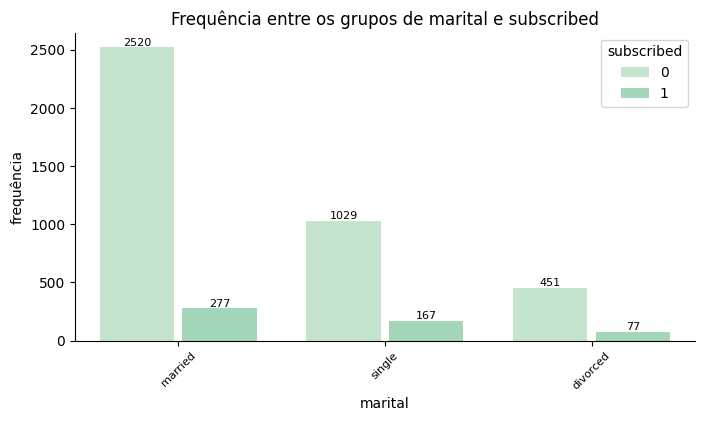

In [40]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='marital', target='subscribed', orient='v')

In [337]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='marital', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis marital e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis marital e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 19.03005634409817
P_valor: 7.373535401823763e-05

----- Conclusão -----
- p_valor: 0.0000737354 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis marital e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.0648787963


##### <code style="color:gold"> Variável education e subscribed (target)  </code>

In [669]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='education', target='subscribed')

,education,subscribed,frequencia,porcentagem
0,primary,0,614,90.560472
1,primary,1,64,9.439528
2,secondary,0,2061,89.375542
3,secondary,1,245,10.624458
4,tertiary,0,1157,85.703704
5,tertiary,1,193,14.296296
6,unknown,0,168,89.839572
7,unknown,1,19,10.160428


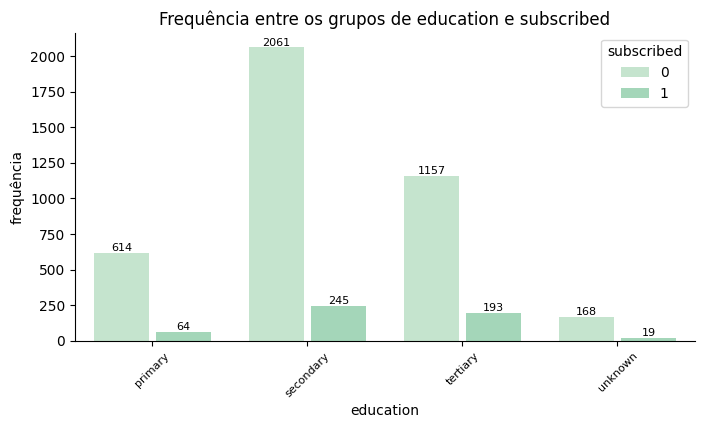

In [39]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='education', target='subscribed', orient='v')

In [340]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='education', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis education e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis education e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 15.236579554873757
P_valor: 0.001625240003630989

----- Conclusão -----
- p_valor: 0.0016252400 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis education e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.0580532434


##### <code style="color:gold"> Variável default e subscribed (target)  </code>

In [671]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='default', target='subscribed')

,default,subscribed,frequencia,porcentagem
0,no,0,3933,88.481440
1,no,1,512,11.518560
2,yes,0,67,88.157895
3,yes,1,9,11.842105


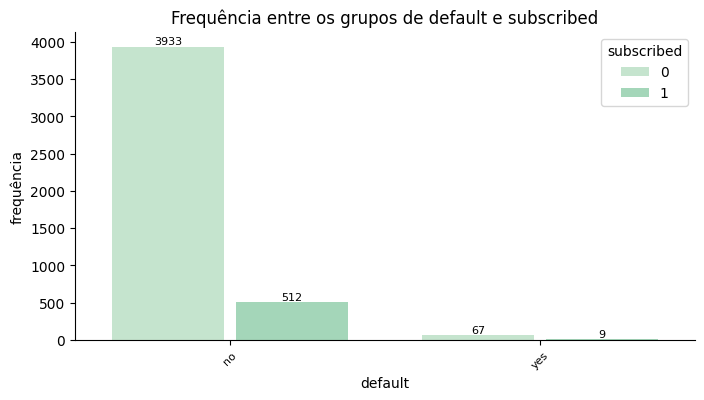

In [38]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='default', target='subscribed', orient='v')

In [345]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='default', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis default e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis default e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 0.0
P_valor: 1.0

----- Conclusão -----
- p_valor: 1.0000000000 > alpha: 0.05 => Não rejeitamos a hipótese nula. Não existe associação entre as variáveis default e subscribed
- Tamanho do Efeito - Cramér´s V: 0.0013026526


##### <code style="color:gold"> Variável housing e subscribed (target)  </code>

In [724]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='housing', target='subscribed')

,housing,subscribed,frequencia,porcentagem
0,no,0,1661,84.658512
1,no,1,301,15.341488
2,yes,0,2339,91.402892
3,yes,1,220,8.597108


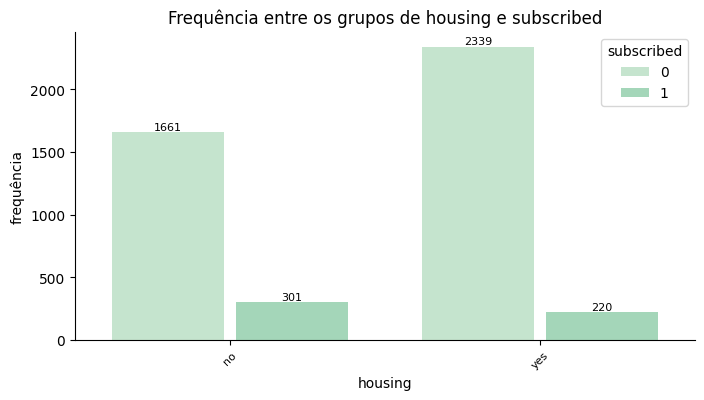

In [37]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='housing', target='subscribed', orient='v')

In [348]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='housing', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis housing e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis housing e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 48.88462833144263
P_valor: 2.7146998959323014e-12

----- Conclusão -----
- p_valor: 0.0000000000 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis housing e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.1046834004


##### <code style="color:gold"> Variável loan e subscribed (target)  </code>

In [723]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='loan', target='subscribed')

,loan,subscribed,frequencia,porcentagem
0,no,0,3352,87.519582
1,no,1,478,12.480418
2,yes,0,648,93.777135
3,yes,1,43,6.222865


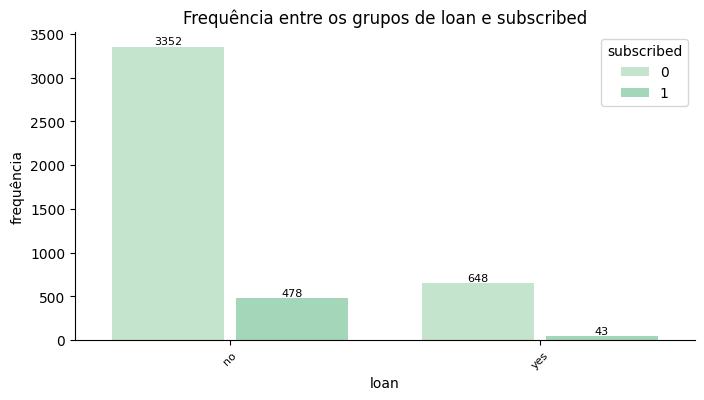

In [36]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='loan', target='subscribed', orient='v')

In [351]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='loan', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis loan e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis loan e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 21.87182161746215
P_valor: 2.9148288298428256e-06

----- Conclusão -----
- p_valor: 0.0000029148 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis loan e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.0705170352


##### <code style="color:gold"> Variável contact e subscribed (target)  </code>

In [722]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='contact', target='subscribed')

,contact,subscribed,frequencia,porcentagem
0,cellular,0,2480,85.635359
1,cellular,1,416,14.364641
2,telephone,0,257,85.382060
3,telephone,1,44,14.617940
4,unknown,0,1263,95.392749
5,unknown,1,61,4.607251


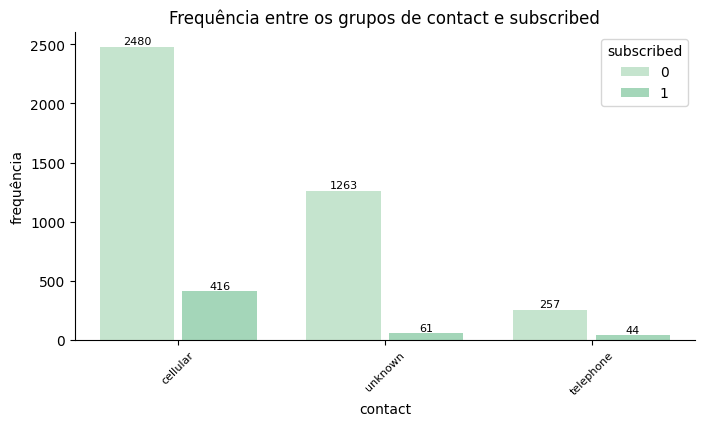

In [35]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='contact', target='subscribed', orient='v')

In [354]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='contact', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis contact e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis contact e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 87.86985650165812
P_valor: 8.30430129641147e-20

----- Conclusão -----
- p_valor: 0.0000000000 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis contact e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.1394128178


##### <code style="color:gold"> Variável month e subscribed (target)  </code>

In [43]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='month', target='subscribed')

,month,subscribed,frequencia,porcentagem
0,apr,0,237,80.887372
1,apr,1,56,19.112628
2,aug,0,554,87.519747
3,aug,1,79,12.480253
4,dec,0,11,55.000000
5,dec,1,9,45.000000
6,feb,0,184,82.882883
7,feb,1,38,17.117117
8,jan,0,132,89.189189
9,jan,1,16,10.810811


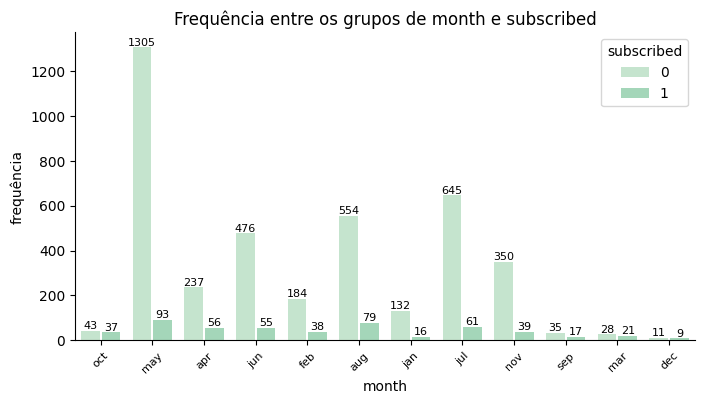

In [44]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='month', target='subscribed', orient='v')

In [45]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='month', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis month e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis month e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 250.50006340911358
P_valor: 2.195354833570811e-47

----- Conclusão -----
- p_valor: 0.0000000000 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis month e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.2353892724


##### <code style="color:gold"> Variável poutcome e subscribed (target)  </code>

In [721]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='poutcome', target='subscribed')

,poutcome,subscribed,frequencia,porcentagem
0,failure,0,427,87.142857
1,failure,1,63,12.857143
2,other,0,159,80.710660
3,other,1,38,19.289340
5,success,0,46,35.658915
4,success,1,83,64.341085
6,unknown,0,3368,90.904184
7,unknown,1,337,9.095816


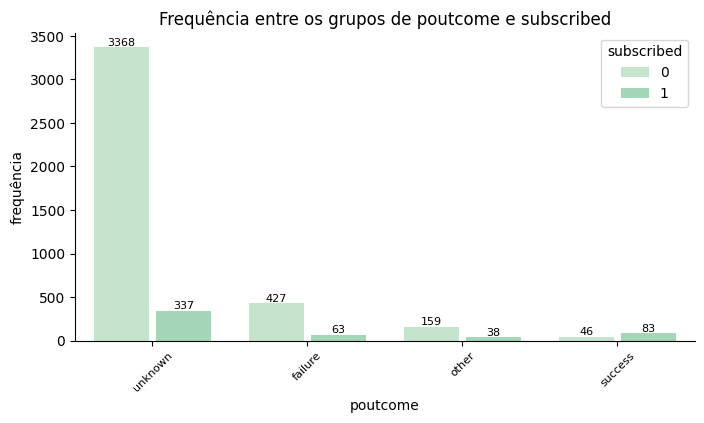

In [46]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='poutcome', target='subscribed', orient='v')

In [365]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='poutcome', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis poutcome e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis poutcome e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 386.8773872252409
P_valor: 1.5398831095860172e-83

----- Conclusão -----
- p_valor: 0.0000000000 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis poutcome e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.2925293321


##### <code style="color:gold"> Variável age_cat e subscribed (target)  </code>

In [726]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='age_cat', target='subscribed')

,age_cat,subscribed,frequencia,porcentagem
0,0_39,0,2031,88.689956
1,0_39,1,259,11.310044
2,40_87,0,1969,88.256387
3,40_87,1,262,11.743613


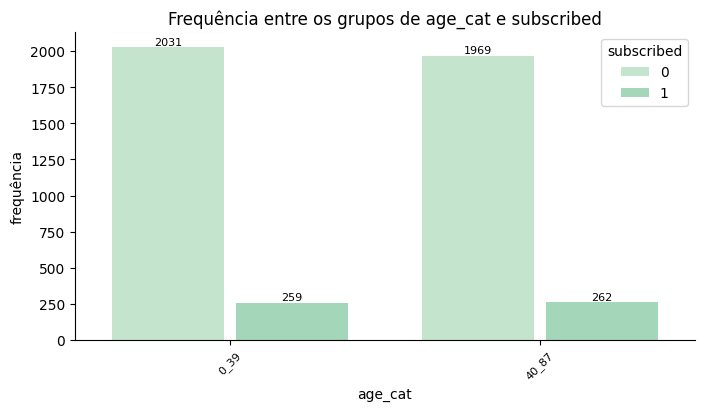

In [47]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='age_cat', target='subscribed', orient='v')

In [463]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='age_cat', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis age_cat e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis age_cat e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 0.16799375616456746
P_valor: 0.681901009703329

----- Conclusão -----
- p_valor: 0.6819010097 > alpha: 0.05 => Não rejeitamos a hipótese nula. Não existe associação entre as variáveis age_cat e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.0067885489


##### <code style="color:gold"> Variável day_cat e subscribed (target)  </code>

In [728]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='day_cat', target='subscribed')

,day_cat,subscribed,frequencia,porcentagem
0,1_12,0,1442,87.980476
1,1_12,1,197,12.019524
2,13_21,0,1579,89.108352
3,13_21,1,193,10.891648
4,22_31,0,979,88.198198
5,22_31,1,131,11.801802


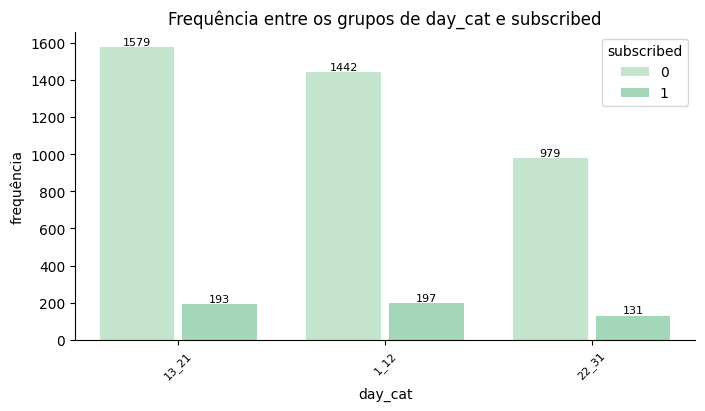

In [48]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='day_cat', target='subscribed', orient='v')

In [466]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='day_cat', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis day_cat e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis day_cat e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 1.1736771143988907
P_valor: 0.5560825318326994

----- Conclusão -----
- p_valor: 0.5560825318 > alpha: 0.05 => Não rejeitamos a hipótese nula. Não existe associação entre as variáveis day_cat e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.0161122824


##### <code style="color:gold"> Variável pdays_cat e subscribed (target)  </code>

In [730]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='pdays_cat', target='subscribed')

,pdays_cat,subscribed,frequencia,porcentagem
0,sem_contato_92,0,3422,90.076336
1,sem_contato_92,1,377,9.923664
2,93_871,0,578,80.055402
3,93_871,1,144,19.944598


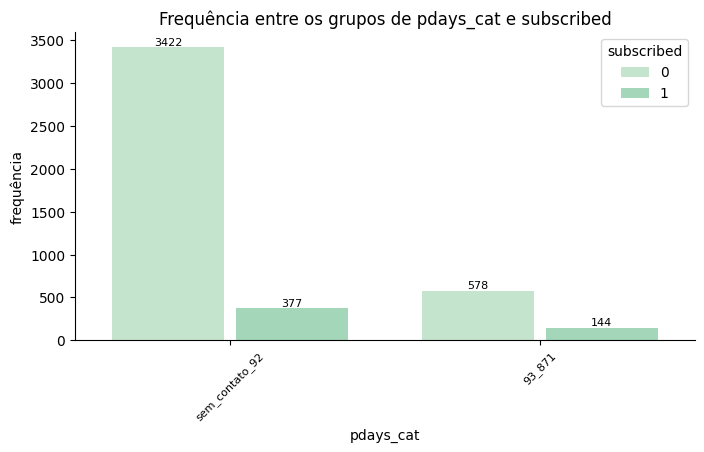

In [49]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='pdays_cat', target='subscribed', orient='v')

In [469]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='pdays_cat', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis pdays_cat e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis pdays_cat e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 58.774207749326706
P_valor: 1.7684432374693093e-14

----- Conclusão -----
- p_valor: 0.0000000000 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis pdays_cat e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.1149641941


##### <code style="color:gold"> Variável previous_cat e subscribed (target)  </code>

In [732]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='previous_cat', target='subscribed')

,previous_cat,subscribed,frequencia,porcentagem
0,0_1,0,3603,90.278126
1,0_1,1,388,9.721874
2,2_25,0,397,74.905660
3,2_25,1,133,25.094340


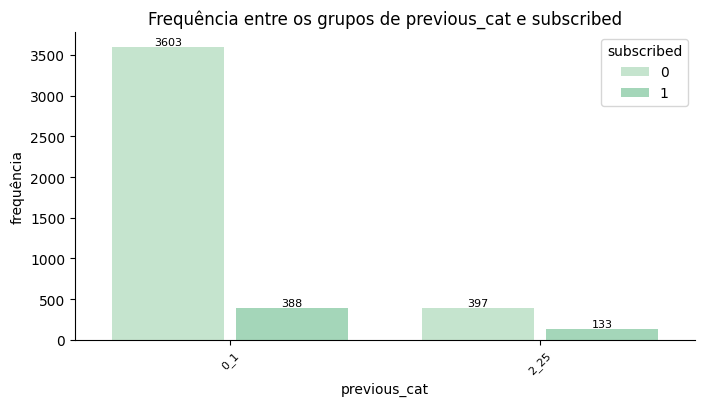

In [50]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='previous_cat', target='subscribed', orient='v')

In [472]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='previous_cat', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis previous_cat e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis previous_cat e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 106.93552598350186
P_valor: 4.598902391379545e-25

----- Conclusão -----
- p_valor: 0.0000000000 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis previous_cat e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.1548721993


<code style="color:gold"> Resultados nível de associação entre as variáveis independentes categóricas e subscribed (target) </code>
- Existe associação entre as variáveis job_cat e subscribed. Tamanho do Efeito - Cramér´s V: 0.0852852208
- Existe associação entre as variáveis marital e subscribed. Tamanho do Efeito - Cramér´s V: 0.0648787963
- Existe associação entre as variáveis education e subscribed. Tamanho do Efeito - Cramér´s V: 0.0580532434
- Não existe associação entre as variáveis default e subscribed. Tamanho do Efeito - Cramér´s V: 0.0013026526
- Existe associação entre as variáveis housing e subscribed. Tamanho do Efeito - Cramér´s V: 0.1046834004
- Existe associação entre as variáveis loan e subscribed. Tamanho do Efeito - Cramér´s V: 0.0705170352
- Existe associação entre as variáveis contact e subscribed. Tamanho do Efeito - Cramér´s V: 0.1394128178
- Existe associação entre as variáveis month_cat e subscribed. Tamanho do Efeito - Cramér´s V: 0.0885800298
- Existe associação entre as variáveis poutcome e subscribed. Tamanho do Efeito - Cramér´s V: 0.2925293321
- Não existe associação entre as variáveis age_cat e subscribed. Tamanho do Efeito - Cramér´s V: 0.0067885489
- Não existe associação entre as variáveis day_cat e subscribed. Tamanho do Efeito - Cramér´s V: 0.0161122824
- Existe associação entre as variáveis pdays_cat e subscribed. Tamanho do Efeito - Cramér´s V: 0.1149641941
- Existe associação entre as variáveis previous_cat e subscribed. Tamanho do Efeito - Cramér´s V: 0.1548721993

### <Code style="color:green"> Insights gerais sobre a associação entre variáveis independentes categóricas e subscribed (target).</code>

<Code style="color:gold"> Clientes incluidos no grupo de trabalho management possuem uma frequência maior de depósitos a prazo assinados.</code>

<Code style="color:gold"> Clientes casados possuem uma frequência maior de depósitos a prazo assinados.</code>

<Code style="color:gold"> Clientes com nível de educação secundário possuem uma frequência maior de depósitos a prazo assinados.</code>

<Code style="color:gold"> Clientes sem crédito em default possuem uma frequência maior de depósitos a prazo assinados.</code>

<Code style="color:gold"> Clientes sem empréstimo habitacional possuem uma frequência maior de depósitos a prazo assinados.</code>

<Code style="color:gold"> Clientes sem empréstimo pessoal possuem uma frequência maior de depósitos a prazo assinados.</code>

<Code style="color:gold"> Clientes contatados via celular possuem uma frequência maior de depósitos a prazo assinados.</code>

<Code style="color:gold"> Clientes contatados durante o mês de maio possuem uma frequência maior de depósitos a prazo assinados.</code>

<Code style="color:gold"> Campanha de marketing anterior com resultado desconhecido possue uma frequência maior de depósitos a prazo assinados.</code>
- Podem ser clientes que estão participando a primeira vez.

<Code style="color:gold"> Clientes com idade na faixa entre 40 e 87 possuem uma frequência maior de depósitos a prazo assinados.</code>

<Code style="color:gold"> Clientes cujo utltimo contato foi entre os dias 1 e 12 possuem uma frequência maior de depósitos a prazo assinados.</code>

<Code style="color:gold"> Clientes que não foram contatados em uma campanha anterior e clientes no qual o número de dias que se passaram foi de até 92, possuem uma frequência maior de depósitos a prazo assinados.</code>

<Code style="color:gold"> Clientes que não foram contatados em uma campanha anterior e clientes que foram contatados somente 1 vez, possuem uma frequência maior de depósitos a prazo assinados.</code>

### <code style="color:green"> Vamos atualizar nosso Dicionário de dados </code>

- <code style="color:gold"> Dados do cliente </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| age    | numérico | Idade do cliente   |Possui assimetria a direita, com variação de 25.69% dos dados em relação a média. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de age não seguem uma distribuição normal. |
|        |          |                    |Sera categorizada. Não possui uma relação linear com y.|
|        |          |                    | Categorizada em 2 grupos [0-39] e [40-87]|
|        |          |                    | Não existe associação entre as variáveis age_cat e subscribed.|
| job    | categórico | Tipo de trabalho |Possui 12 grupos. | 
|        |          |                    |O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros. |
|        |          |                    |A maioria dos clientes trabalha como management, com 21.43% dos casos. |
|        |          |                    | Será necessário um tratamento na nomenclatura do grupos. |
|        |          |                    |Existe associação entre as variáveis job e subscribed. |
| marital   | categórico| Estado civil | Possui 3 grupos.|
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes é casada, com 61.87% dos casos. |
|        |          |                    |Existe associação entre as variáveis marital e subscribed. |
| education    | categórico| Educação |Possui 4 grupos. |
|        |          |                    |Os grupos estão desbalanceados. O grupo unknown possui um volume de dados abaixo de 300 registros.|
|        |          |                    |A maioria dos clientes tem o grau de educação secondary, com 51% dos casos. |
|        |          |                    | Existe associação entre as variáveis education e subscribed.|
- <code style="color:gold"> Dados bancários </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| default | binário: "yes","no" | tem crédito em default? | Possui 2 grupos. |
|        |          |                    |Os grupos estão desbalanceados, sendo que grupo yes possui um volume de dados abaixo de 300 registros.|
|        |          |                    |A maioria dos clientes não tem crédito em default, com 98.32% dos casos.|
|        |          |                    | Não existe associação entre as variáveis default e subscribed. |
| balance | numérico | saldo médio anual, em euros |Possui forte assimetria a direita, com variação de 211.55% dos dados em relação a média. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de balance não seguem uma distribuição normal. |
|        |          |                    |Possui uma relação linear com y.|
| housing | binário: "yes","no" | tem empréstimo habitacional? | Possui 2 grupos. |
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes tem empréstimo habitacional, com 56.60% dos casos.|
|        |          |                    | Existe associação entre as variáveis housing e subscribed. |
| loan | binário: "yes","no" | tem empréstimo pessoal? |Possui 2 grupos. |
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes não tem empréstimo pessoal, com 84.72% dos casos.|
|        |          |                    | Existe associação entre as variáveis loan e subscribed. |

- <code style="color:gold"> Dados relacionados com o ultimo contato da campanha atual </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| contact | categórico | tipo de comunicação do contato | Possui 3 grupos.|
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes foram contatados através do celular, com 64.05% dos casos.|
|        |          |                    | Existe associação entre as variáveis contact e subscribed. |
| day | numérico |  último dia de contato do mês | Não possui outliers.|
|     |          |                               | Os dados de day não seguem uma distribuição normal.|
|        |          |                    |Sera categorizada. Não possui uma relação linear com y.|
|        |          |                    | Categorizada em 3 grupos [1-12], [13-21], e [22-31]|
|        |          |                    | Não existe associação entre as variáveis day_cat e subscribed. |
| month | categórico | último mês de contato do ano |Possui 12 grupos. |
|        |          |                    |O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.|
|        |          |                    |A maioria do ultimo mês de contato do ano foi em maio, com 30.92% dos casos.|
|        |          |                    | Existe associação entre as variáveis month e subscribed. |
| duration | numérico | duração do último contato, em segundos | Possui forte assimetria a direita, com variação dos dados em relação a média de 98.44%.|
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de duration não seguem uma distribuição normal. |
|        |          |                    |Possui uma relação linear com y.|
| campaign | numérico | número de contatos realizados durante esta campanha e para este cliente (inclui o último contato) |Possui forte assimetria a direita, com variação dos dados em relação a média de 111.32%. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de campaign não seguem uma distribuição normal. |
|        |          |                    |Possui uma relação linear com y.|
| pdays | numérico | número de dias que se passaram desde que o cliente foi contatado pela última vez em uma campanha anterior (-1 significa que o cliente não foi contatado anteriormente) |Possui forte assimetria a direita, com variação dos dados em relação a média de 251.77%. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de campaign não seguem uma distribuição normal. |
|        |          |                    |Sera categorizada. Não possui uma relação linear com y.|
|        |          |                    | Categorizada em 2 grupos [-1-92] e [93-871]|
|        |          |                    | Existe associação entre as variáveis pdays_cat e subscribed.|
| previous | numérico | número de contatos realizados antes desta campanha e para este cliente | Possui forte assimetria a direita, com variação dos dados em relação a média de 312.13%. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de campaign não seguem uma distribuição normal. |
|        |          |                    |Sera categorizada. Não possui uma relação linear com y.|
|        |          |                    | Categorizada em 2 grupos [0-1] e [2-25]|
|        |          |                    | Existe associação entre as variáveis previous_cat e subscribed|
| poutcome | categórico | resultado da campanha de marketing anterior | Possui 4 grupos.|
|        |          |                    |O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.|
|        |          |                    |A maioria do resultado da campanha de marketing anterior é unknown, com 81.95% dos casos.|
|        |          |                    | Existe associação entre as variáveis poutcome e subscribed. |

- <code style="color:gold"> Variável target (objetivo) </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| y | binário: "yes","no" | o cliente assinou um depósito a prazo? | Possui 2 grupos.|
|        |          |                    |O volume de dados entre os grupos é desbalanceado 12% para assinou um depósito a prazo e 88% para `não` assinou um depósito a prazo. Por se tratar da variável do objetivo desejado, este desbalanceamento, precisa de atenção.|
|        |          |                    |Será necessario realizar um tratamento nos dados, convertendo yes=1 e no=0.|



<code style="color:gold"> Referência: </code>

  This dataset is public available for research. The details are described in [Moro et al., 2011]. 

  Please include this citation if you plan to use this database:

  [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

##### <code style='color:green'> Realizando um tratamento na nomenclatura do grupos da variável job </code>

In [79]:
df_bank_marketing['job'] = df_bank_marketing['job'].replace({
    'admin.': 'admin',
    'blue-collar': 'blue_collar',
    'entrepreneur': 'entrepreneur',
    'housemaid': 'housemaid',
    'management': 'management',
    'retired': 'retired',
    'self-employed': 'self_employed',
    'services': 'services',
    'student': 'student',
    'technician': 'technician',
    'unemployed': 'unemployed',
    'unknown': 'unknown'
})

In [80]:
# Salvando o dataframe tratado em um novo arquivo CSV
df_bank_marketing.to_csv('../data/bank_marketing_tratado.csv', sep=';', index=False)

### <code style="color:green"> Analisando o nível de significancia (p_valor e IC95) entre as variáveis independentes e subscribed (target) </code>
- Variáveis numéricas com relação linear com y (balance, duration, campaign).
- Variáveis categóricas com associação com y (job_cat, marital, education, housing, loan, contact, month_cat, poutcome, pdays_cat, previous_cat).


In [81]:
# Lendo o arquivo tratado
df_modelo = pd.read_csv('../data/bank_marketing_tratado.csv', sep=';')
df_modelo.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,y,subscribed,age_cat,day_cat,pdays_cat,previous_cat
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,1,-1,0,unknown,no,0,0_39,13_21,sem_contato_92,0_1
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,1,339,4,failure,no,0,0_39,1_12,93_871,2_25
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,1,330,1,failure,no,0,0_39,13_21,93_871,0_1
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,4,-1,0,unknown,no,0,0_39,1_12,sem_contato_92,0_1
4,59,blue_collar,married,secondary,no,0,yes,no,unknown,5,...,1,-1,0,unknown,no,0,40_87,1_12,sem_contato_92,0_1


In [82]:
eda_df_modelo = eda.Eda_lib(dataframe=df_modelo, nome="df_modelo", colormap="mako_r" )

##### <code style="color:gold"> Variável balance e subscribed (target)  </code>

In [55]:
model =smf.glm(formula='subscribed ~ balance', data=df_modelo, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4519
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1614.8
Date:                qua, 31 dez 2025   Deviance:                       3229.7
Time:                        20:53:57   Pearson chi2:                 4.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0002938
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0626      0.051    -40.315      0.000      -2.163      -1.962
balance     1.641e-05   1.37e-05      1.198      0.231   -1.04e-05    4.33e-05
==============================================================================
"""

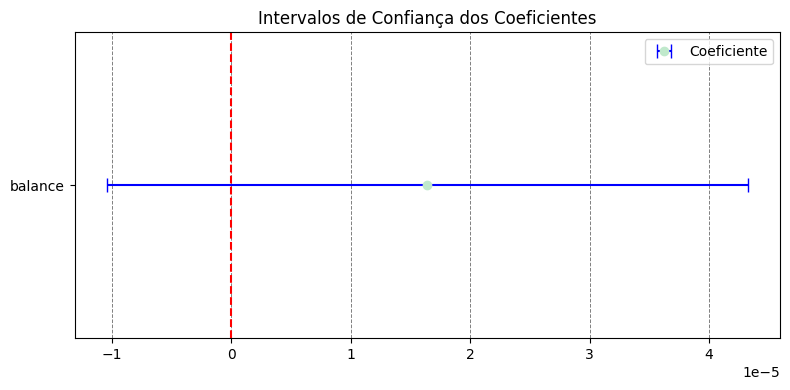

In [56]:
rl.plot_IC95(model=model)

##### <code style="color:gold"> Variável duration e subscribed (target)  </code>

In [57]:
model =smf.glm(formula='subscribed ~ duration', data=df_modelo, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4519
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1350.9
Date:                qua, 31 dez 2025   Deviance:                       2701.8
Time:                        20:54:16   Pearson chi2:                 5.80e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1105
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2559      0.085    -38.497      0.000      -3.422      -3.090
duration       0.0035      0.000     20.714      0.000       0.003       0.004
==============================================================================
"""

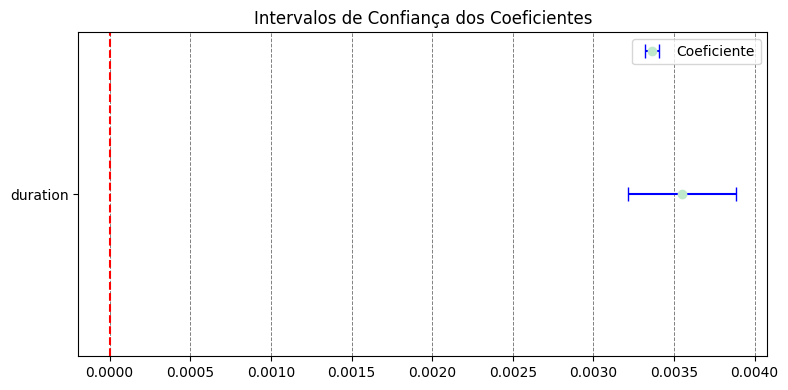

In [58]:
rl.plot_IC95(model=model)

##### <code style="color:gold"> Variável campaign e subscribed (target)  </code>

In [59]:
model =smf.glm(formula='subscribed ~ campaign', data=df_modelo, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4519
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1604.2
Date:                qua, 31 dez 2025   Deviance:                       3208.5
Time:                        20:54:25   Pearson chi2:                 4.54e+03
No. Iterations:                     6   Pseudo R-squ. (CS):           0.004970
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7965      0.071    -25.324      0.000      -1.936      -1.657
campaign      -0.0961      0.023     -4.141      0.000      -0.142      -0.051
==============================================================================
"""

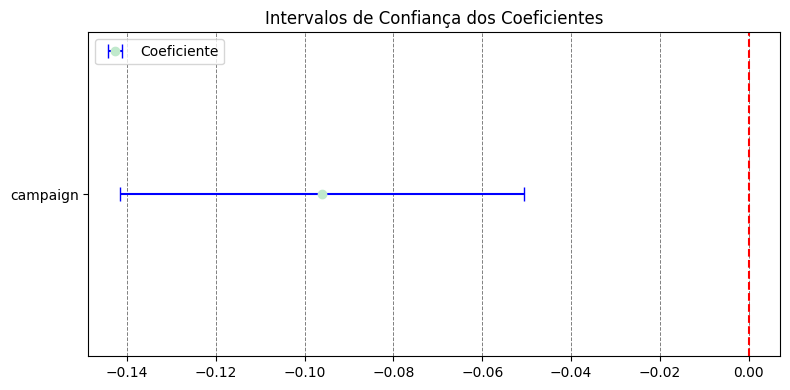

In [60]:
rl.plot_IC95(model=model)

##### <code style="color:gold"> Variável job e subscribed (target)  </code>

In [83]:
# Criando as variaveis dummies para a variável job
job_dummies = pd.get_dummies(df_modelo['job'], prefix='job', drop_first=False, dtype=int)
job_dummies.head()

,job_admin,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0


In [84]:
eda_df_modelo.taxa_resposta(var_categorica='job', target='subscribed')

,job,frequencia,taxa_resposta
0,admin,478,0.121339
1,blue_collar,946,0.072939
2,entrepreneur,168,0.089286
3,housemaid,112,0.125000
4,management,969,0.135191
5,retired,230,0.234783
6,self_employed,183,0.109290
7,services,417,0.091127
8,student,84,0.226190
9,technician,768,0.108073


In [91]:
# concatenando as variaveis dummies ao dataframe original
df_job_dummies = pd.concat([df_modelo[['subscribed','job']], job_dummies],  axis=1)
df_job_dummies.head()

,subscribed,job,job_admin,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,0,unemployed,0,0,0,0,0,0,0,0,0,0,1,0
1,0,services,0,0,0,0,0,0,0,1,0,0,0,0
2,0,management,0,0,0,0,1,0,0,0,0,0,0,0
3,0,management,0,0,0,0,1,0,0,0,0,0,0,0
4,0,blue_collar,0,1,0,0,0,0,0,0,0,0,0,0


In [92]:
model =smf.glm(formula='subscribed ~ job_admin + job_blue_collar + job_entrepreneur + job_housemaid + job_retired + job_self_employed + job_services + job_student + job_technician + job_unemployed + job_unknown' ,
                data=df_job_dummies, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4509
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1584.2
Date:                qui, 01 jan 2026   Deviance:                       3168.4
Time:                        13:08:28   Pearson chi2:                 4.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01375
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.8558      0.094    -19.753      0.000      -2.040      -1.672
job_admin            -0.1240      0.169     -0.735      0.462      -0.455       0.207
job_blue_collar      -0.6866      0.156     -4.390      0.000      -0.993      -0.380
job_entrepreneur     -0.4666      0.286     -1.629      0.103      -1.028       0.095
job_housemaid        -0.0901      0.301     -0.300      0.765      -0.680       0.499
job_retired           0.6743      0.182      3.710      0.000       0.318       1.031
job_self_employed    -0.2422      0.255     -0.950      0.342      -0.742       0.257
job_services         -0.4441      0.194     -2.285      0.022      -0.825      -0.063
job_student           0.6259      0.277      2.258      0.024       0.083       1.169
job_technician       -0.2548      0.149     -1.705      0.088      -0.548       0.038
job_unemployed       -0.3242      0.307     -1.055      0.292      -0.926       0.278
job_unknown           0.3677      0.429      0.857      0.391      -0.473       1.208
=====================================================================================
"""

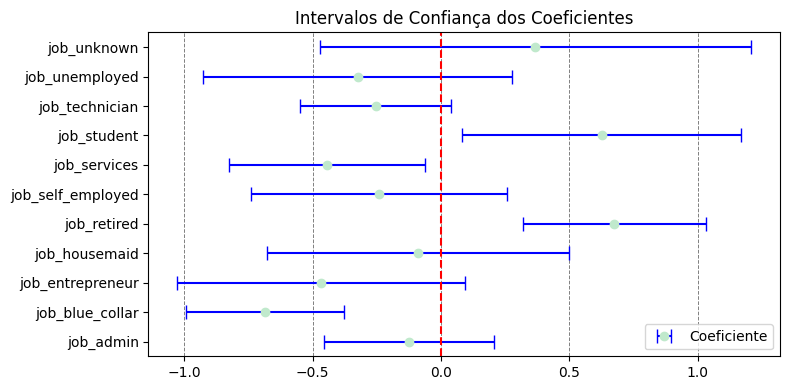

In [93]:
rl.plot_IC95(model=model)

In [94]:
model.pvalues > 0.05

Intercept            False
job_admin             True
job_blue_collar      False
job_entrepreneur      True
job_housemaid         True
job_retired          False
job_self_employed     True
job_services         False
job_student          False
job_technician        True
job_unemployed        True
job_unknown           True
dtype: bool

<code style="color:gold"> Através do p_valor e IC95, observamos que algumas variáveis se mostraram não significativas em relação a variável job_management (casela). Irei agrupá-las. </code>

In [111]:
# agrupando as categorias da variável job
df_modelo['job_cat'] = df_modelo['job'].replace({
    'admin': 'management_others',
    'blue_collar': 'blue_collar',
    'entrepreneur': 'management_others',
    'housemaid': 'management_others',
    'management': 'management_others',
    'retired': 'retired',
    'self_employed': 'management_others',
    'services': 'services',
    'student': 'student',
    'technician': 'management_others',
    'unemployed': 'management_others',
    'unknown': 'management_others'
})

In [113]:
# Criando as variaveis dummies para a variável job
job_dummies = pd.get_dummies(df_modelo['job_cat'], prefix='job', drop_first=False, dtype=int)
job_dummies.head()

,job_blue_collar,job_management_others,job_retired,job_services,job_student
0,0,1,0,0,0
1,0,0,0,1,0
2,0,1,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0


In [114]:
# concatenando as variaveis dummies ao dataframe original
df_job_dummies = pd.DataFrame()
df_job_dummies = pd.concat([df_modelo[['subscribed','job_cat']], job_dummies],  axis=1)
df_job_dummies.head()

,subscribed,job_cat,job_blue_collar,job_management_others,job_retired,job_services,job_student
0,0,management_others,0,1,0,0,0
1,0,services,0,0,0,1,0
2,0,management_others,0,1,0,0,0
3,0,management_others,0,1,0,0,0
4,0,blue_collar,1,0,0,0,0


In [115]:
eda_df_modelo.taxa_resposta(var_categorica='job_cat', target='subscribed')

,job_cat,frequencia,taxa_resposta
0,blue_collar,946,0.072939
1,management_others,2844,0.119902
2,retired,230,0.234783
3,services,417,0.091127
4,student,84,0.226190


In [116]:
model =smf.glm(formula='subscribed ~ job_blue_collar + job_retired + job_services + job_student',
                data=df_job_dummies, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4516
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1587.5
Date:                qui, 01 jan 2026   Deviance:                       3175.1
Time:                        13:27:42   Pearson chi2:                 4.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01229
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.9934      0.058    -34.533      0.000      -2.106      -1.880
job_blue_collar    -0.5490      0.138     -3.987      0.000      -0.819      -0.279
job_retired         0.8119      0.166      4.893      0.000       0.487       1.137
job_services       -0.3066      0.180     -1.706      0.088      -0.659       0.046
job_student         0.7634      0.267      2.858      0.004       0.240       1.287
===================================================================================
"""

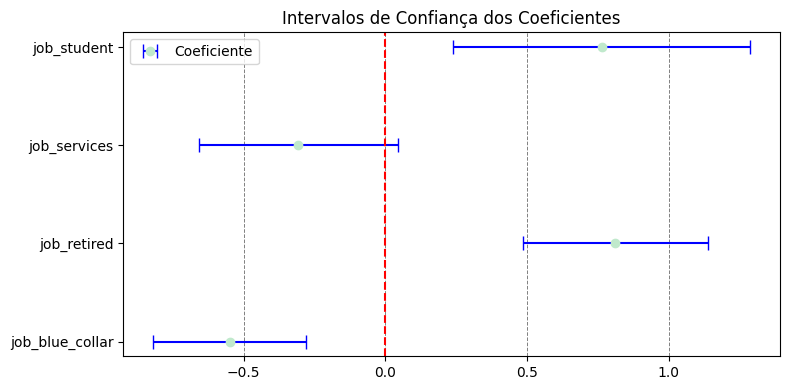

In [117]:
rl.plot_IC95(model=model)

<code style="color:gold"> Através do p_valor e IC95, observamos que algumas variáveis se mostraram não significativas em relação a variável job_management (casela). Irei reagrupá-las. </code>

In [118]:
model.pvalues > 0.05

Intercept          False
job_blue_collar    False
job_retired        False
job_services        True
job_student        False
dtype: bool

In [119]:
# agrupando as categorias da variável job
df_modelo['job_cat'] = df_modelo['job'].replace({
    'admin': 'management_others',
    'blue_collar': 'blue_collar',
    'entrepreneur': 'management_others',
    'housemaid': 'management_others',
    'management': 'management_others',
    'retired': 'retired',
    'self_employed': 'management_others',
    'services': 'management_others',
    'student': 'student',
    'technician': 'management_others',
    'unemployed': 'management_others',
    'unknown': 'management_others'
})

In [120]:
# Criando as variaveis dummies para a variável job
job_dummies = pd.get_dummies(df_modelo['job_cat'], prefix='job', drop_first=False, dtype=int)
job_dummies.head()

,job_blue_collar,job_management_others,job_retired,job_student
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0


In [121]:
# concatenando as variaveis dummies ao dataframe original
df_job_dummies = pd.DataFrame()
df_job_dummies = pd.concat([df_modelo[['subscribed','job_cat']], job_dummies],  axis=1)
df_job_dummies.head()

,subscribed,job_cat,job_blue_collar,job_management_others,job_retired,job_student
0,0,management_others,0,1,0,0
1,0,management_others,0,1,0,0
2,0,management_others,0,1,0,0
3,0,management_others,0,1,0,0
4,0,blue_collar,1,0,0,0


In [122]:
eda_df_modelo.taxa_resposta(var_categorica='job_cat', target='subscribed')

,job_cat,frequencia,taxa_resposta
0,blue_collar,946,0.072939
1,management_others,3261,0.116222
2,retired,230,0.234783
3,student,84,0.226190


In [123]:
model =smf.glm(formula='subscribed ~ job_blue_collar + job_retired + job_student',
                data=df_job_dummies, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4517
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1589.1
Date:                qui, 01 jan 2026   Deviance:                       3178.2
Time:                        13:31:55   Pearson chi2:                 4.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01161
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.0287      0.055    -37.129      0.000      -2.136      -1.922
job_blue_collar    -0.5137      0.136     -3.765      0.000      -0.781      -0.246
job_retired         0.8472      0.165      5.138      0.000       0.524       1.170
job_student         0.7988      0.266      2.998      0.003       0.277       1.321
===================================================================================
"""

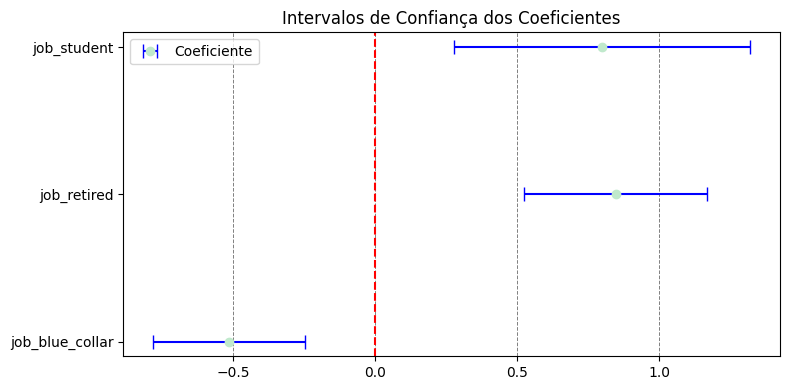

In [124]:
rl.plot_IC95(model=model)

In [125]:
# Concatenado as dummies de job_cat ao dataframe original
df_modelo = pd.concat([df_modelo, job_dummies], axis=1)
df_modelo.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,subscribed,age_cat,day_cat,pdays_cat,previous_cat,job_cat,job_blue_collar,job_management_others,job_retired,job_student
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,0,0_39,13_21,sem_contato_92,0_1,management_others,0,1,0,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,0,0_39,1_12,93_871,2_25,management_others,0,1,0,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,0,0_39,13_21,93_871,0_1,management_others,0,1,0,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,0,0_39,1_12,sem_contato_92,0_1,management_others,0,1,0,0
4,59,blue_collar,married,secondary,no,0,yes,no,unknown,5,...,0,40_87,1_12,sem_contato_92,0_1,blue_collar,1,0,0,0


In [126]:
# Salvando o dataframe modelo para modelagem em um novo arquivo CSV
df_modelo.to_csv('../data/bank_marketing_modelo.csv', sep=';', index=False)

##### <code style="color:gold"> Variável marital e subscribed (target)  </code>

In [127]:
# Criando as dummies para a variavel marital
marital_dummies = pd.get_dummies(df_modelo['marital'], prefix='marital', drop_first=False, dtype=int)
marital_dummies.head()

,marital_divorced,marital_married,marital_single
0,0,1,0
1,0,1,0
2,0,0,1
3,0,1,0
4,0,1,0


In [128]:
# Concatenar as dummies ao dataframe original
df_marital_dummies = pd.concat([df_modelo['subscribed'], marital_dummies], axis=1)
df_marital_dummies.head()

,subscribed,marital_divorced,marital_married,marital_single
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,0,0,1,0
4,0,0,1,0


In [129]:
eda_df_modelo.taxa_resposta(var_categorica='marital', target='subscribed')

,marital,frequencia,taxa_resposta
0,divorced,528,0.145833
1,married,2797,0.099035
2,single,1196,0.139632


In [130]:
model =smf.glm(formula='subscribed ~ marital_single + marital_divorced', data=df_marital_dummies, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4518
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1606.2
Date:                qui, 01 jan 2026   Deviance:                       3212.4
Time:                        13:37:43   Pearson chi2:                 4.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.004112
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.2080      0.063    -34.881      0.000      -2.332      -2.084
marital_single       0.3896      0.105      3.721      0.000       0.184       0.595
marital_divorced     0.4403      0.139      3.177      0.001       0.169       0.712
====================================================================================
"""

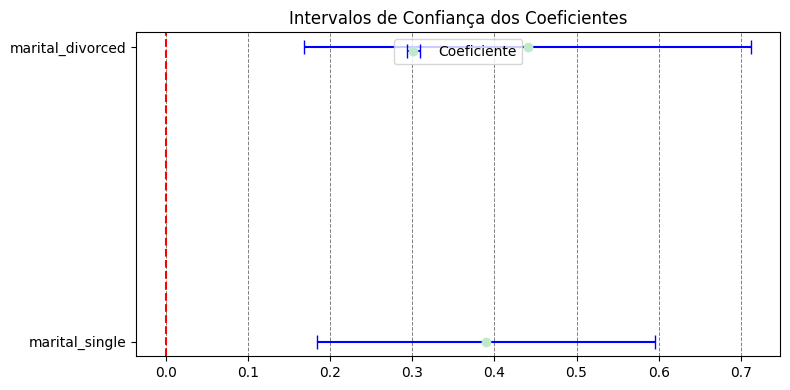

In [131]:
rl.plot_IC95(model=model)

In [132]:
# Concatenado as dummies de marital ao dataframe original
df_modelo = pd.concat([df_modelo, marital_dummies], axis=1)
df_modelo.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,pdays_cat,previous_cat,job_cat,job_blue_collar,job_management_others,job_retired,job_student,marital_divorced,marital_married,marital_single
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,sem_contato_92,0_1,management_others,0,1,0,0,0,1,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,93_871,2_25,management_others,0,1,0,0,0,1,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,93_871,0_1,management_others,0,1,0,0,0,0,1
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,sem_contato_92,0_1,management_others,0,1,0,0,0,1,0
4,59,blue_collar,married,secondary,no,0,yes,no,unknown,5,...,sem_contato_92,0_1,blue_collar,1,0,0,0,0,1,0


In [133]:
# Salvando o dataframe modelo para modelagem em um novo arquivo CSV
df_modelo.to_csv('../data/bank_marketing_modelo.csv', sep=';', index=False)

##### <code style="color:gold"> Variável education e subscribed (target)  </code>

In [134]:
# Criando as variaveis dummies para a variável education
education_dummies = pd.get_dummies(df_modelo['education'], prefix='education', drop_first=False, dtype=int)
education_dummies.head()

,education_primary,education_secondary,education_tertiary,education_unknown
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,1,0
4,0,1,0,0


In [135]:
# Concatenar as dummies ao dataframe original
df_education_dummies = pd.concat([df_modelo['subscribed'], education_dummies], axis=1)
df_education_dummies.head()

,subscribed,education_primary,education_secondary,education_tertiary,education_unknown
0,0,1,0,0,0
1,0,0,1,0,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,1,0,0


In [136]:
eda_df_modelo.taxa_resposta(var_categorica='education', target='subscribed')

,education,frequencia,taxa_resposta
0,primary,678,0.094395
1,secondary,2306,0.106245
2,tertiary,1350,0.142963
3,unknown,187,0.101604


In [137]:
model =smf.glm(formula='subscribed ~ education_primary + education_secondary + education_unknown', data=df_education_dummies, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4517
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1608.1
Date:                qui, 01 jan 2026   Deviance:                       3216.2
Time:                        13:48:56   Pearson chi2:                 4.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.003274
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.7909      0.078    -23.033      0.000      -1.943      -1.639
education_primary      -0.4702      0.153     -3.081      0.002      -0.769      -0.171
education_secondary    -0.3388      0.103     -3.289      0.001      -0.541      -0.137
education_unknown      -0.3886      0.254     -1.529      0.126      -0.887       0.110
=======================================================================================
"""

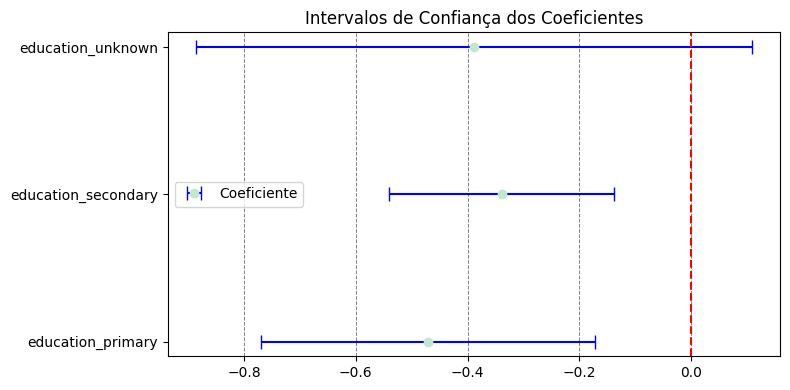

In [138]:
rl.plot_IC95(model=model)

<code style="color:gold"> Através do p_valor e IC95, observamos que algumas variáveis se mostraram não significativa em relação a variável education_tertiary (casela). Irei agrupá-las. </code>

In [139]:
# reagrupando a variável education
df_modelo['education_cat'] = df_modelo['education'].replace({
    'tertiary': 'tertiary_unknown',
    'secondary': 'secondary',
    'primary': 'primary',
    'unknown': 'tertiary_unknown',
})

In [140]:
# Criando as variaveis dummies para a variável education
education_dummies = pd.get_dummies(df_modelo['education_cat'], prefix='education', drop_first=False, dtype=int)
education_dummies.head()

,education_primary,education_secondary,education_tertiary_unknown
0,1,0,0
1,0,1,0
2,0,0,1
3,0,0,1
4,0,1,0


In [141]:
# Concatenar as dummies ao dataframe original
df_education_dummies = pd.concat([df_modelo['subscribed'], education_dummies], axis=1)
df_education_dummies.head()

,subscribed,education_primary,education_secondary,education_tertiary_unknown
0,0,1,0,0
1,0,0,1,0
2,0,0,0,1
3,0,0,0,1
4,0,0,1,0


In [145]:
eda_df_modelo.taxa_resposta(var_categorica='education_cat', target='subscribed')

,education_cat,frequencia,taxa_resposta
0,primary,678,0.094395
1,secondary,2306,0.106245
2,tertiary_unknown,1537,0.137931


In [146]:
model =smf.glm(formula='subscribed ~ education_primary + education_secondary', data=df_education_dummies, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4518
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1609.4
Date:                qui, 01 jan 2026   Deviance:                       3218.7
Time:                        13:54:46   Pearson chi2:                 4.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.002714
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.8326      0.074    -24.774      0.000      -1.978      -1.688
education_primary      -0.4285      0.151     -2.843      0.004      -0.724      -0.133
education_secondary    -0.2971      0.100     -2.965      0.003      -0.493      -0.101
=======================================================================================
"""

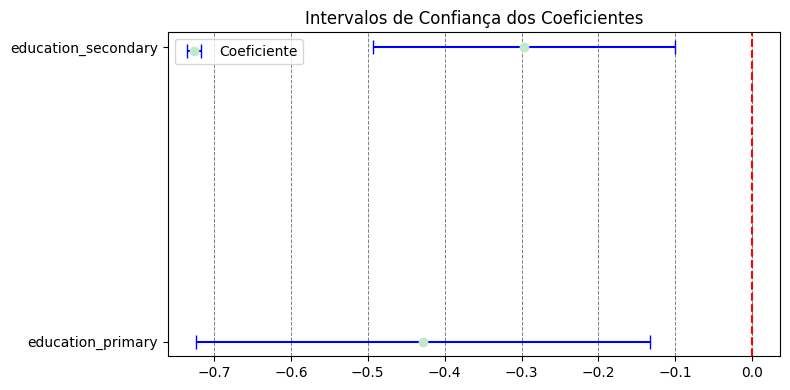

In [147]:
rl.plot_IC95(model=model)

In [148]:
# Concatenado as dummies de education ao dataframe original
df_modelo = pd.concat([df_modelo, education_dummies], axis=1)
df_modelo.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,job_management_others,job_retired,job_student,marital_divorced,marital_married,marital_single,education_cat,education_primary,education_secondary,education_tertiary_unknown
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,1,0,0,0,1,0,primary,1,0,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,1,0,0,0,1,0,secondary,0,1,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,1,0,0,0,0,1,tertiary_unknown,0,0,1
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,1,0,0,0,1,0,tertiary_unknown,0,0,1
4,59,blue_collar,married,secondary,no,0,yes,no,unknown,5,...,0,0,0,0,1,0,secondary,0,1,0


In [149]:
# Salvando o dataframe modelo para modelagem em um novo arquivo CSV
df_modelo.to_csv('../data/bank_marketing_modelo.csv', sep=';', index=False)

##### <code style="color:gold"> Variável housing e subscribed (target)  </code>

In [150]:
# criando as dummies para a variável housing
housing_dummies = pd.get_dummies(df_modelo['housing'], prefix='housing', drop_first=False, dtype=int)
housing_dummies.head()

,housing_no,housing_yes
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1


In [151]:
# Concatenar as dummies ao dataframe original
df_housing_dummies = pd.concat([df_modelo['subscribed'], housing_dummies], axis=1)
df_housing_dummies.head()

,subscribed,housing_no,housing_yes
0,0,1,0
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [152]:
eda_df_modelo.taxa_resposta(var_categorica='housing', target='subscribed')

,housing,frequencia,taxa_resposta
0,no,1962,0.153415
1,yes,2559,0.085971


In [153]:
model =smf.glm(formula='subscribed ~ housing_yes', data=df_housing_dummies, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4519
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1591.0
Date:                qui, 01 jan 2026   Deviance:                       3181.9
Time:                        13:57:23   Pearson chi2:                 4.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01079
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.7081      0.063    -27.266      0.000      -1.831      -1.585
housing_yes    -0.6558      0.094     -6.952      0.000      -0.841      -0.471
===============================================================================
"""

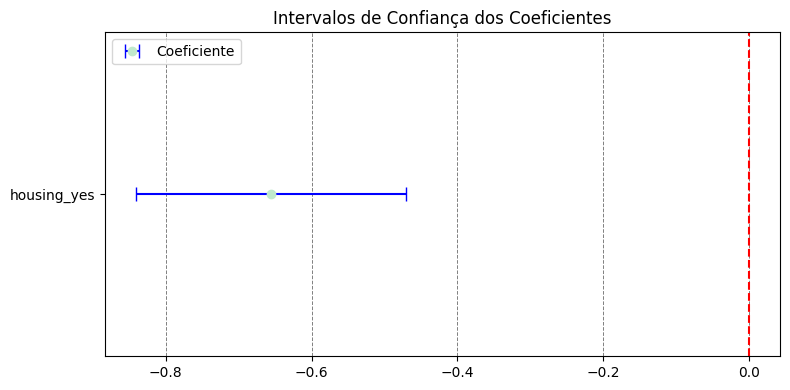

In [154]:
rl.plot_IC95(model=model)

In [155]:
# concatenar as dummies ao dataframe original
df_modelo = pd.concat([df_modelo, housing_dummies], axis=1)
df_modelo.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,job_student,marital_divorced,marital_married,marital_single,education_cat,education_primary,education_secondary,education_tertiary_unknown,housing_no,housing_yes
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,0,0,1,0,primary,1,0,0,1,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,0,0,1,0,secondary,0,1,0,0,1
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,0,0,0,1,tertiary_unknown,0,0,1,0,1
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,0,0,1,0,tertiary_unknown,0,0,1,0,1
4,59,blue_collar,married,secondary,no,0,yes,no,unknown,5,...,0,0,1,0,secondary,0,1,0,0,1


In [156]:
# Salvando o dataframe modelo para modelagem em um novo arquivo CSV
df_modelo.to_csv('../data/bank_marketing_modelo.csv', sep=';', index=False)

##### <code style="color:gold"> Variável loan e subscribed (target)  </code>

In [157]:
# Criando as dummies para a variavel loan
loan_dummies = pd.get_dummies(df_modelo['loan'], prefix='loan', drop_first=False, dtype=int)
loan_dummies.head()

,loan_no,loan_yes
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0


In [158]:
# concatenar as dummies ao dataframe original
df_loan_dummies = pd.concat([df_modelo['subscribed'], loan_dummies], axis=1)
df_loan_dummies.head()

,subscribed,loan_no,loan_yes
0,0,1,0
1,0,0,1
2,0,1,0
3,0,0,1
4,0,1,0


In [159]:
eda_df_modelo.taxa_resposta(var_categorica='loan', target='subscribed')

,loan,frequencia,taxa_resposta
0,no,3830,0.124804
1,yes,691,0.062229


In [160]:
model =smf.glm(formula='subscribed ~ loan_yes', data=df_loan_dummies, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4519
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1602.6
Date:                qui, 01 jan 2026   Deviance:                       3205.2
Time:                        13:58:19   Pearson chi2:                 4.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.005685
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9477      0.049    -39.837      0.000      -2.044      -1.852
loan_yes      -0.7650      0.165     -4.639      0.000      -1.088      -0.442
==============================================================================
"""

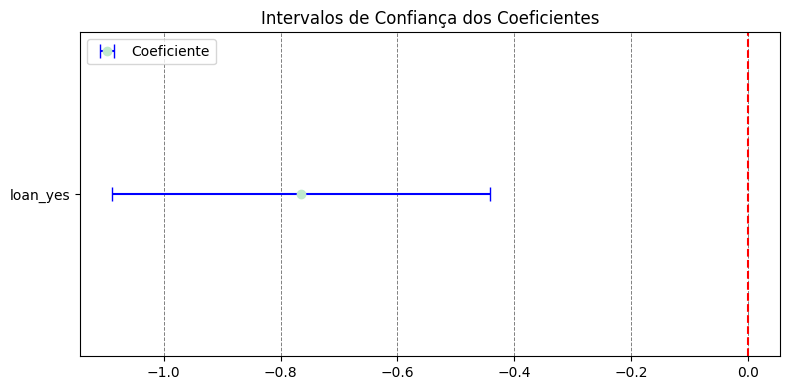

In [161]:
rl.plot_IC95(model=model)

In [162]:
# concatenar as dummies ao dataframe original
df_modelo = pd.concat([df_modelo, loan_dummies], axis=1)
df_modelo.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,marital_married,marital_single,education_cat,education_primary,education_secondary,education_tertiary_unknown,housing_no,housing_yes,loan_no,loan_yes
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,1,0,primary,1,0,0,1,0,1,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,1,0,secondary,0,1,0,0,1,0,1
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,0,1,tertiary_unknown,0,0,1,0,1,1,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,1,0,tertiary_unknown,0,0,1,0,1,0,1
4,59,blue_collar,married,secondary,no,0,yes,no,unknown,5,...,1,0,secondary,0,1,0,0,1,1,0


In [163]:
# Salvando o dataframe modelo para modelagem em um novo arquivo CSV
df_modelo.to_csv('../data/bank_marketing_modelo.csv', sep=';', index=False)

##### <code style="color:gold"> Variável contact e subscribed (target)  </code>

In [164]:
# criando as dummies para a variável contact
contact_dummies = pd.get_dummies(df_modelo['contact'], prefix='contact', drop_first=False, dtype=int)
contact_dummies.head()

,contact_cellular,contact_telephone,contact_unknown
0,1,0,0
1,1,0,0
2,1,0,0
3,0,0,1
4,0,0,1


In [165]:
# concatenar as dummies ao dataframe original
df_contact_dummies = pd.concat([df_modelo['subscribed'], contact_dummies], axis=1)
df_contact_dummies.head()

,subscribed,contact_cellular,contact_telephone,contact_unknown
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,0,0,1
4,0,0,0,1


In [167]:
eda_df_modelo.taxa_resposta(var_categorica='contact', target='subscribed')

,contact,frequencia,taxa_resposta
0,cellular,2896,0.143646
1,telephone,301,0.146179
2,unknown,1324,0.046073


In [168]:
model =smf.glm(formula='subscribed ~ contact_unknown + contact_telephone', data=df_contact_dummies, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4518
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1564.3
Date:                qui, 01 jan 2026   Deviance:                       3128.6
Time:                        14:00:13   Pearson chi2:                 4.52e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02239
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.7853      0.053    -33.697      0.000      -1.889      -1.681
contact_unknown      -1.2450      0.141     -8.805      0.000      -1.522      -0.968
contact_telephone     0.0204      0.172      0.119      0.905      -0.316       0.357
=====================================================================================
"""

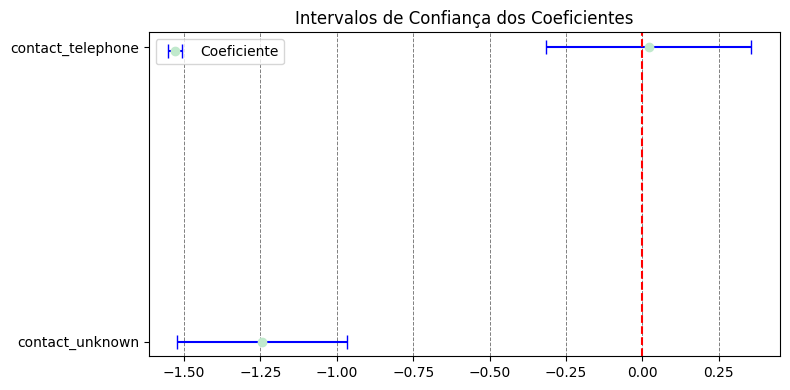

In [169]:
rl.plot_IC95(model=model)

<code style="color:gold"> Através do p_valor e IC95, observamos que a variável contact_telephone se mostrou não significativa em relação a variável contact_cellular (casela). Irei agrupá-las. </code>

In [170]:
# reagrupando a variável contact
df_modelo['contact_cat'] = df_modelo['contact'].replace({
    'cellular': 'cellular_telephone',
    'telephone': 'cellular_telephone',
    'unknown': 'unknown'
})

In [180]:
# criando as dummies para a variável contact_cat
contact_dummies = pd.get_dummies(df_modelo['contact_cat'], prefix='contact', drop_first=False, dtype=int)
contact_dummies.head()

,contact_cellular_telephone,contact_unknown
0,1,0
1,1,0
2,1,0
3,0,1
4,0,1


In [183]:
# concatenar as dummies ao dataframe original
df_contact_dummies = pd.concat([df_modelo['subscribed'], contact_dummies], axis=1)
df_contact_dummies.head()

,subscribed,contact_cellular_telephone,contact_unknown
0,0,1,0
1,0,1,0
2,0,1,0
3,0,0,1
4,0,0,1


In [182]:
eda_df_modelo.taxa_resposta(var_categorica='contact_cat', target='subscribed')

,contact_cat,frequencia,taxa_resposta
0,cellular_telephone,3197,0.143885
1,unknown,1324,0.046073


In [588]:
model =smf.glm(formula='subscribed ~ contact_unknown', data=df_contact_dummies, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4519
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1564.3
Date:                qua, 07 jan 2026   Deviance:                       3128.6
Time:                        15:04:06   Pearson chi2:                 4.52e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02239
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.7834      0.050    -35.391      0.000      -1.882      -1.685
contact_unknown    -1.2470      0.140     -8.879      0.000      -1.522      -0.972
===================================================================================
"""

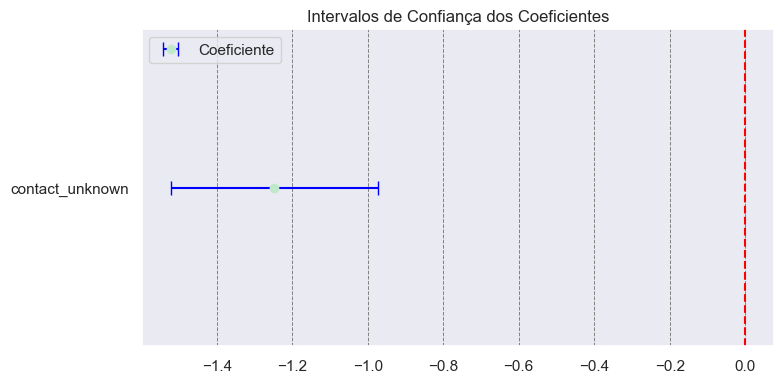

In [589]:
rl.plot_IC95(model=model)

In [189]:
# concatenar as dummies ao dataframe original
df_modelo = pd.concat([df_modelo, contact_dummies], axis=1)
df_modelo.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,education_primary,education_secondary,education_tertiary_unknown,housing_no,housing_yes,loan_no,loan_yes,contact_cat,contact_cellular_telephone,contact_unknown
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,1,0,0,1,0,1,0,cellular_telephone,1,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,0,1,0,0,1,0,1,cellular_telephone,1,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,0,0,1,0,1,1,0,cellular_telephone,1,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,0,0,1,0,1,0,1,unknown,0,1
4,59,blue_collar,married,secondary,no,0,yes,no,unknown,5,...,0,1,0,0,1,1,0,unknown,0,1


In [190]:
# Salvando o dataframe modelo para modelagem em um novo arquivo CSV
df_modelo.to_csv('../data/bank_marketing_modelo.csv', sep=';', index=False)

##### <code style="color:gold"> Variável month e subscribed (target)  </code>

In [209]:
# reagrupando a variável month
df_modelo['month_cat'] = df_modelo['month'].replace({
    'jan': 'q1',
    'feb': 'q1',
    'mar': 'q1',
    'apr': 'q2',
    'may': 'q2',
    'jun': 'q2',
    'jul': 'q3',
    'aug': 'q3',
    'sep': 'q3',
    'oct': 'q4',
    'nov': 'q4',
    'dec': 'q4'
})


In [210]:
# criando as dummies para a variável month
month_dummies = pd.get_dummies(df_modelo['month_cat'], prefix='month', drop_first=False, dtype=int)
month_dummies.head()

,month_q1,month_q2,month_q3,month_q4
0,0,0,0,1
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [211]:
# concatenar as dummies ao dataframe original
df_month_dummies = pd.concat([df_modelo['subscribed'], month_dummies], axis=1)
df_month_dummies.head()

,subscribed,month_q1,month_q2,month_q3,month_q4
0,0,0,0,0,1
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0


In [212]:
eda_df_modelo.taxa_resposta(var_categorica='month_cat', target='subscribed')

,month_cat,frequencia,taxa_resposta
0,q1,419,0.178998
1,q2,2222,0.091809
2,q3,1391,0.112868
3,q4,489,0.173824


In [213]:
model =smf.glm(formula='subscribed ~ month_q1 + month_q3 + month_q4',
                data=df_month_dummies, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4517
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1594.5
Date:                qui, 01 jan 2026   Deviance:                       3189.1
Time:                        14:29:02   Pearson chi2:                 4.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.009235
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2917      0.073    -31.194      0.000      -2.436      -2.148
month_q1       0.7686      0.147      5.225      0.000       0.480       1.057
month_q3       0.2300      0.112      2.051      0.040       0.010       0.450
month_q4       0.7330      0.140      5.231      0.000       0.458       1.008
==============================================================================
"""

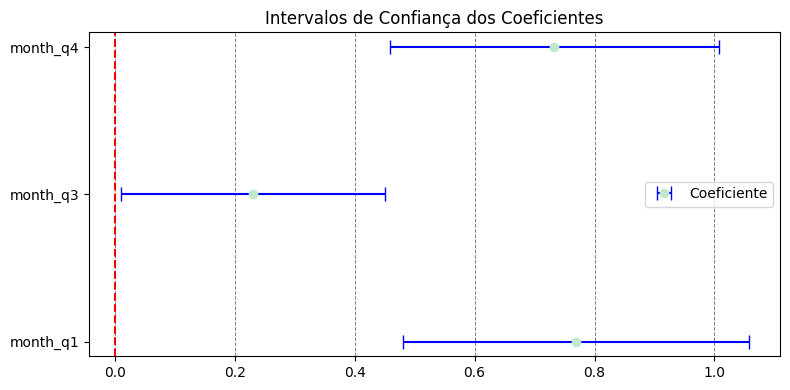

In [214]:
rl.plot_IC95(model=model)

In [219]:
# concatenar as dummies ao dataframe original
df_modelo = pd.concat([df_modelo, month_dummies], axis=1)
df_modelo.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,loan_no,loan_yes,contact_cat,contact_cellular_telephone,contact_unknown,month_cat,month_q1,month_q2,month_q3,month_q4
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,1,0,cellular_telephone,1,0,q4,0,0,0,1
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,0,1,cellular_telephone,1,0,q2,0,1,0,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,1,0,cellular_telephone,1,0,q2,0,1,0,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,0,1,unknown,0,1,q2,0,1,0,0
4,59,blue_collar,married,secondary,no,0,yes,no,unknown,5,...,1,0,unknown,0,1,q2,0,1,0,0


In [220]:
# Salvando o dataframe modelo para modelagem em um novo arquivo CSV
df_modelo.to_csv('../data/bank_marketing_modelo.csv', sep=';', index=False)

##### <code style="color:gold"> Variável poutcome e subscribed (target)  </code>

In [228]:
# criando as dummies para a variável poutcome
poutcome_dummies = pd.get_dummies(df_modelo['poutcome'], prefix='poutcome', drop_first=False, dtype=int)
poutcome_dummies.head()

,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,0,0,1
1,1,0,0,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


In [229]:
# concatenar as dummies ao dataframe original
df_poutcome_dummies = pd.concat([df_modelo['subscribed'], poutcome_dummies], axis=1)
df_poutcome_dummies.head()

,subscribed,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,0,0,0,1
1,0,1,0,0,0
2,0,1,0,0,0
3,0,0,0,0,1
4,0,0,0,0,1


In [230]:
eda_df_modelo.taxa_resposta(var_categorica='poutcome', target='subscribed')

,poutcome,frequencia,taxa_resposta
0,failure,490,0.128571
1,other,197,0.192893
2,success,129,0.643411
3,unknown,3705,0.090958


In [232]:
model =smf.glm(formula='subscribed ~ poutcome_other + poutcome_success + poutcome_failure', data=df_poutcome_dummies, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4517
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1497.7
Date:                qui, 01 jan 2026   Deviance:                       2995.5
Time:                        14:40:31   Pearson chi2:                 4.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.05076
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.3020      0.057    -40.291      0.000      -2.414      -2.190
poutcome_other       0.8707      0.189      4.597      0.000       0.499       1.242
poutcome_success     2.8922      0.192     15.025      0.000       2.515       3.269
poutcome_failure     0.3883      0.147      2.650      0.008       0.101       0.676
====================================================================================
"""

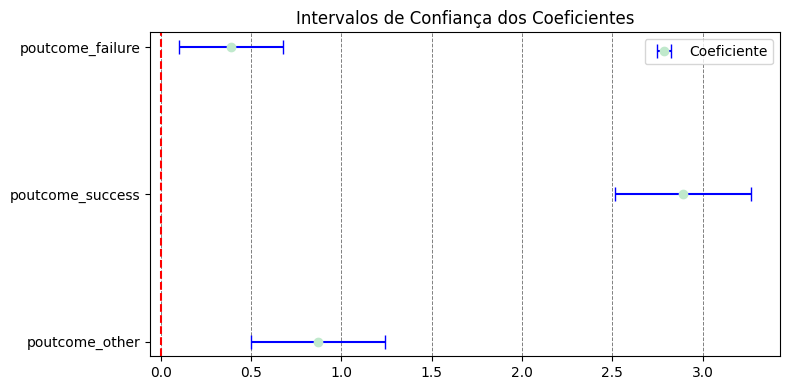

In [233]:
rl.plot_IC95(model=model)

In [234]:
# concatenar as dummies ao dataframe original
df_modelo = pd.concat([df_modelo, poutcome_dummies], axis=1)
df_modelo.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,contact_unknown,month_cat,month_q1,month_q2,month_q3,month_q4,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,0,q4,0,0,0,1,0,0,0,1
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,0,q2,0,1,0,0,1,0,0,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,0,q2,0,1,0,0,1,0,0,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,1,q2,0,1,0,0,0,0,0,1
4,59,blue_collar,married,secondary,no,0,yes,no,unknown,5,...,1,q2,0,1,0,0,0,0,0,1


In [235]:
# salvando o dataframe modelo final para modelagem em um novo arquivo CSV
df_modelo.to_csv('../data/bank_marketing_modelo.csv', sep=';', index=False)

##### <code style="color:gold"> Variável pdays_cat e subscribed (target)  </code>

In [236]:
# criar as variaveis dummies para a variável pdays_cat
pdays_dummies = pd.get_dummies(df_modelo['pdays_cat'], prefix='pdays', drop_first=False, dtype=int)
pdays_dummies.head()

,pdays_93_871,pdays_sem_contato_92
0,0,1
1,1,0
2,1,0
3,0,1
4,0,1


In [237]:
# concatenando as variaveis dummies ao dataframe original
df_pdays_dummies = pd.concat([df_modelo['subscribed'], pdays_dummies], axis=1)
df_pdays_dummies.head()

,subscribed,pdays_93_871,pdays_sem_contato_92
0,0,0,1
1,0,1,0
2,0,1,0
3,0,0,1
4,0,0,1


In [238]:
eda_df_modelo.taxa_resposta(var_categorica='pdays_cat', target='subscribed')

,pdays_cat,frequencia,taxa_resposta
0,93_871,722,0.199446
1,sem_contato_92,3799,0.099237


In [239]:
model =smf.glm(formula='subscribed ~ pdays_93_871', data=df_pdays_dummies, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4519
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1589.3
Date:                qui, 01 jan 2026   Deviance:                       3178.7
Time:                        14:45:30   Pearson chi2:                 4.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01151
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.2057      0.054    -40.647      0.000      -2.312      -2.099
pdays_93_871     0.8160      0.108      7.570      0.000       0.605       1.027
================================================================================
"""

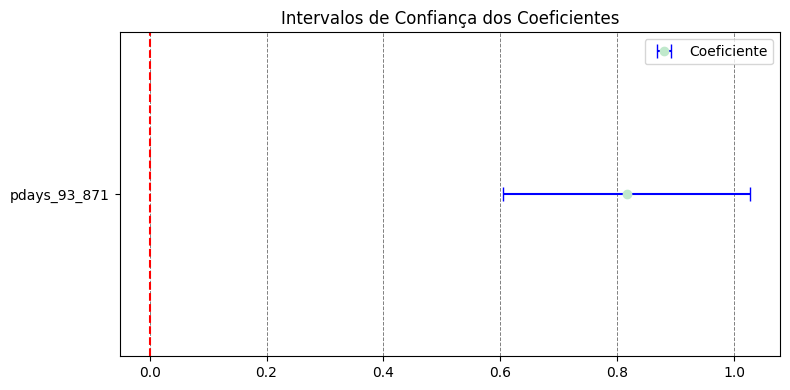

In [240]:
rl.plot_IC95(model=model)

In [243]:
# concatenar as dummies ao dataframe original
df_modelo = pd.concat([df_modelo, pdays_dummies], axis=1)
df_modelo.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_q1,month_q2,month_q3,month_q4,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,pdays_93_871,pdays_sem_contato_92
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,0,0,0,1,0,0,0,1,0,1
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,0,1,0,0,1,0,0,0,1,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,0,1,0,0,1,0,0,0,1,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,0,1,0,0,0,0,0,1,0,1
4,59,blue_collar,married,secondary,no,0,yes,no,unknown,5,...,0,1,0,0,0,0,0,1,0,1


In [244]:
# Salvando o dataframe modelo para modelagem em um novo arquivo CSV
df_modelo.to_csv('../data/bank_marketing_modelo.csv', sep=';', index=False)

##### <code style="color:gold"> Variável previous_cat e subscribed (target)  </code>

In [245]:
# criando as variaveis dummies para a variável previous_cat
previous_dummies = pd.get_dummies(df_modelo['previous_cat'], prefix='previous', drop_first=False, dtype=int)
previous_dummies.head()

,previous_0_1,previous_2_25
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0


In [246]:
# concatenar as dummies ao dataframe original
df_previous_dummies = pd.concat([df_modelo['subscribed'], previous_dummies], axis=1)
df_previous_dummies.head()

,subscribed,previous_0_1,previous_2_25
0,0,1,0
1,0,0,1
2,0,1,0
3,0,1,0
4,0,1,0


In [247]:
eda_df_modelo.taxa_resposta(var_categorica='previous_cat', target='subscribed')

,previous_cat,frequencia,taxa_resposta
0,0_1,3991,0.097219
1,2_25,530,0.250943


In [249]:
model =smf.glm(formula='subscribed ~ previous_2_25', data=df_previous_dummies, family=sma.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4519
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1571.4
Date:                qui, 01 jan 2026   Deviance:                       3142.9
Time:                        14:51:03   Pearson chi2:                 4.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01931
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.2285      0.053    -41.708      0.000      -2.333      -2.124
previous_2_25     1.1349      0.114      9.995      0.000       0.912       1.357
=================================================================================
"""

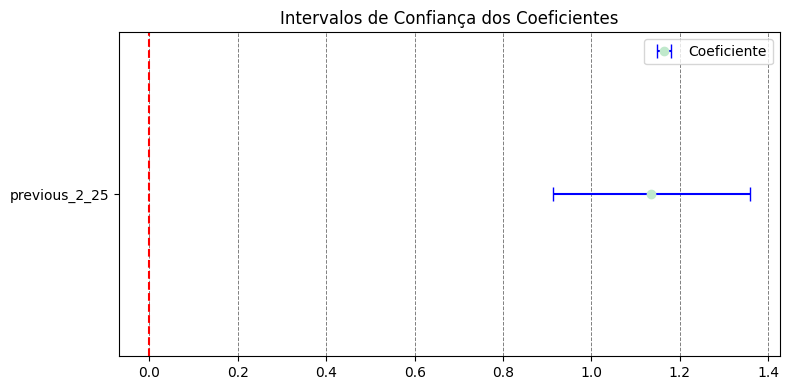

In [250]:
rl.plot_IC95(model=model)

In [251]:
# concatenar as dummies ao dataframe original
df_modelo = pd.concat([df_modelo, previous_dummies], axis=1)
df_modelo.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_q3,month_q4,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,pdays_93_871,pdays_sem_contato_92,previous_0_1,previous_2_25
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,0,1,0,0,0,1,0,1,1,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,0,0,1,0,0,0,1,0,0,1
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,0,0,1,0,0,0,1,0,1,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,0,0,0,0,0,1,0,1,1,0
4,59,blue_collar,married,secondary,no,0,yes,no,unknown,5,...,0,0,0,0,0,1,0,1,1,0


<code style="color:gold"> Resultados da análise do nível de significancia (p_valor e IC95) entre as variáveis independentes e subscribed (target) </code>
- balance: p_valor: 0.231 > 0.05 | IC95: abrange o valor zero. Não significativa para o modelo.
- duration: p_valor: 0.000 < 0.05 | IC95: Não abrange o valor zero. Significativa para o modelo.
- campaign: p_valor: 0.000 < 0.05 | IC95: Não abrange o valor zero. Significativa para o modelo.
- job: dummies job_retired, job_student, job_blue_collar e job_management_others (casela) são significativas para o modelo.
- marital: dummies marital_divorced, marital_single e marital_married (casela) são significativas para o modelo.
- education: dummies education_primary, education_secondary e education_tertiary_unknown (casela) são significativas para o modelo.
- housing: dummies housing_no (casela) e housing_yes são significativas para o modelo.
- loan: dummies loan_yes e loan_no (casela) são significativas para o modelo.
- contact: dummies contact_unknown e contact_cellular_telephone (casela) são significativas para o modelo.
- month: dummies month_q1, month_q2 (casela), month_q3, month_q4 são significativas para o modelo.
- poutcome: dummies poutcome_other, poutcome_success, poutcome_unknown (casela) e poutcome_failure são significativas para o modelo.
- pdays_cat: dummies pdays_93_871 e pdays_sem_contato_92 (casela)
- previous_cat: dummies previous_0_1 (casela) e previous_2_25 são significativas para o modelo.

### <code style='color:green'> Construindo o modelo inicial </code>

In [337]:
formula = 'subscribed ~ balance + duration + campaign + job_retired + job_student + job_blue_collar + marital_single + marital_divorced + education_primary + education_secondary + housing_yes + loan_yes + contact_unknown + month_q1 + month_q3 + month_q4 + poutcome_other + poutcome_success + poutcome_failure + pdays_93_871 + previous_2_25'

In [338]:
model_full = smf.glm(formula, data=df_modelo, family=sma.families.Binomial()).fit()
model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4499
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1135.8
Date:                sex, 02 jan 2026   Deviance:                       2271.6
Time:                        21:30:31   Pearson chi2:                 1.15e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1912
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.8150      0.198    -14.220      0.000      -3.203      -2.427
balance             -8.632e-07   1.82e-05     -0.048      0.962   -3.64e-05    3.47e-05
duration                0.0040      0.000     20.786      0.000       0.004       0.004
campaign               -0.0604      0.027     -2.227      0.026      -0.113      -0.007
job_retired             0.7416      0.214      3.462      0.001       0.322       1.161
job_student             0.5454      0.315      1.733      0.083      -0.072       1.162
job_blue_collar        -0.2920      0.175     -1.667      0.096      -0.635       0.051
marital_single          0.2291      0.132      1.733      0.083      -0.030       0.488
marital_divorced        0.4471      0.168      2.663      0.008       0.118       0.776
education_primary      -0.3025      0.200     -1.512      0.130      -0.695       0.090
education_secondary    -0.2092      0.124     -1.681      0.093      -0.453       0.035
housing_yes            -0.4935      0.126     -3.917      0.000      -0.740      -0.247
loan_yes               -0.6919      0.193     -3.581      0.000      -1.071      -0.313
contact_unknown        -1.2689      0.196     -6.466      0.000      -1.653      -0.884
month_q1                0.0364      0.191      0.191      0.849      -0.338       0.411
month_q3               -0.3384      0.163     -2.081      0.037      -0.657      -0.020
month_q4               -0.0408      0.185     -0.221      0.825      -0.403       0.321
poutcome_other          0.7213      0.361      1.998      0.046       0.014       1.429
poutcome_success        2.6972      0.349      7.723      0.000       2.013       3.382
poutcome_failure        0.2670      0.344      0.775      0.438      -0.408       0.942
pdays_93_871           -0.6678      0.291     -2.294      0.022      -1.238      -0.097
previous_2_25           0.6332      0.234      2.709      0.007       0.175       1.091
=======================================================================================
"""

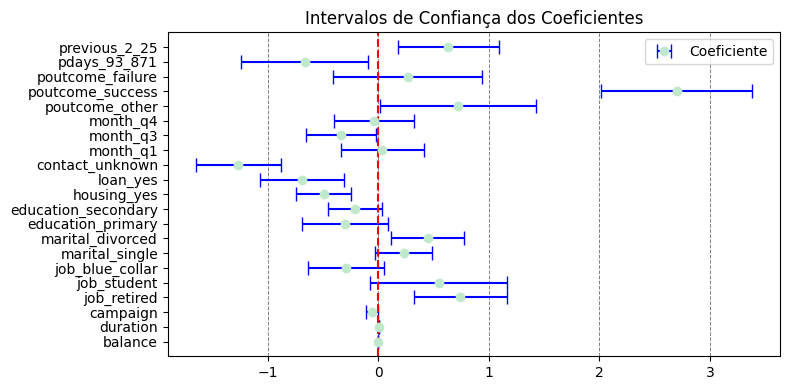

In [341]:
rl.plot_IC95(model=model_full)


In [332]:
model_full.pvalues > 0.05

Intercept              False
balance                 True
duration               False
campaign               False
job_retired            False
job_student             True
job_blue_collar         True
marital_single          True
marital_divorced       False
education_primary       True
education_secondary     True
housing_yes            False
loan_yes               False
contact_unknown        False
month_q1                True
month_q3               False
month_q4                True
poutcome_other         False
poutcome_success       False
poutcome_failure        True
pdays_93_871           False
previous_2_25          False
dtype: bool

<code style=color:gold> Na presença de todas as variáveis, as variáveis abaixo não foram significativas, portanto: </code>
- job_student e job_blue_collar poden ser agrupado com job_management_others (casela)
- marital_single pode ser agrupado com  marital_married (casela)
- education_primary pode ser agrupado com education_tertiary_unknown (casela)
- education_secondary pode ser agrupado com education_tertiary_unknown (casela)
- month_q1 pode ser agrupado com month_q2 (casela)
- month_q4 pode ser agrupado com month_q2 (casela)
- poutcome_failure pode ser agrupado com poutcome_unknown (casela)


In [359]:
# lendo o dataframe modelo final
df_modelo = pd.read_csv('../data/bank_marketing_modelo.csv', sep=';')
df_modelo.head()           

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_q3,month_q4,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,pdays_93_871,pdays_sem_contato_92,previous_0_1,previous_2_25
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,0,1,0,0,0,1,0,1,1,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,0,0,1,0,0,0,1,0,0,1
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,0,0,1,0,0,0,1,0,1,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,0,0,0,0,0,1,0,1,1,0
4,59,blue_collar,married,secondary,no,0,yes,no,unknown,5,...,0,0,0,0,0,1,0,1,1,0


In [360]:
# selecionar as variaveis de df_modelo que começamcom job_
var_job = [col for col in df_modelo.columns if col.startswith('job_')]
var_job

['job_cat',
 'job_blue_collar',
 'job_management_others',
 'job_retired',
 'job_student']

In [362]:
# deletar as colunas de var_job do dataframe df_modelo_final
df_modelo.drop(columns=['job_management_others',
                        'job_blue_collar',
 'job_retired',
 'job_student'], inplace=True, axis=1)

In [366]:
eda_df_modelo.taxa_resposta(var_categorica='job_cat', target='subscribed')

,job_cat,frequencia,taxa_resposta
0,blue_collar,946,0.072939
1,management_others,3261,0.116222
2,retired,230,0.234783
3,student,84,0.226190


In [368]:
# agrupando as categorias de job_cat
df_modelo['job_cat'] = df_modelo['job_cat'].replace({
    'blue_collar': 'management_others',
    'student': 'management_others',
})                                                 


In [369]:
# criando as variaveis dummies para a variável job_cat
job_dummies = pd.get_dummies(df_modelo['job_cat'], prefix='job', drop_first=False, dtype=int)
job_dummies.head()

,job_management_others,job_retired
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [370]:
# concatenando as variaveis dummies ao dataframe original
df_modelo = pd.concat([df_modelo, job_dummies], axis=1)

In [371]:
formula = 'subscribed ~ balance + duration + campaign + job_retired + marital_single + marital_divorced + education_primary + education_secondary + housing_yes + loan_yes + contact_unknown + month_q1 + month_q3 + month_q4 + poutcome_other + poutcome_success + poutcome_failure + pdays_93_871 + previous_2_25'

In [372]:
model_full = smf.glm(formula, data=df_modelo, family=sma.families.Binomial()).fit()
model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4501
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1138.8
Date:                sáb, 03 jan 2026   Deviance:                       2277.6
Time:                        21:35:09   Pearson chi2:                 1.03e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1901
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.8169      0.197    -14.267      0.000      -3.204      -2.430
balance              9.094e-08   1.81e-05      0.005      0.996   -3.54e-05    3.55e-05
duration                0.0040      0.000     20.750      0.000       0.004       0.004
campaign               -0.0598      0.027     -2.209      0.027      -0.113      -0.007
job_retired             0.7999      0.210      3.807      0.000       0.388       1.212
marital_single          0.2867      0.129      2.228      0.026       0.035       0.539
marital_divorced        0.4619      0.168      2.758      0.006       0.134       0.790
education_primary      -0.4215      0.187     -2.259      0.024      -0.787      -0.056
education_secondary    -0.2456      0.122     -2.018      0.044      -0.484      -0.007
housing_yes            -0.5327      0.125     -4.261      0.000      -0.778      -0.288
loan_yes               -0.7148      0.193     -3.706      0.000      -1.093      -0.337
contact_unknown        -1.2802      0.196     -6.537      0.000      -1.664      -0.896
month_q1                0.0443      0.191      0.232      0.817      -0.330       0.419
month_q3               -0.3322      0.163     -2.044      0.041      -0.651      -0.014
month_q4               -0.0207      0.184     -0.112      0.911      -0.382       0.341
poutcome_other          0.7270      0.360      2.018      0.044       0.021       1.433
poutcome_success        2.6964      0.349      7.731      0.000       2.013       3.380
poutcome_failure        0.2616      0.344      0.761      0.447      -0.412       0.936
pdays_93_871           -0.6797      0.290     -2.341      0.019      -1.249      -0.111
previous_2_25           0.6594      0.234      2.822      0.005       0.201       1.117
=======================================================================================
"""

In [373]:
model_full.pvalues > 0.05

Intercept              False
balance                 True
duration               False
campaign               False
job_retired            False
marital_single         False
marital_divorced       False
education_primary      False
education_secondary    False
housing_yes            False
loan_yes               False
contact_unknown        False
month_q1                True
month_q3               False
month_q4                True
poutcome_other         False
poutcome_success       False
poutcome_failure        True
pdays_93_871           False
previous_2_25          False
dtype: bool

<code style=color:gold> Na presença de todas as variáveis, as variáveis abaixo não foram significativas, portanto: </code>
- month_q1 pode ser agrupado com month_q2 (casela)
- month_q4 pode ser agrupado com month_q2 (casela)
- poutcome_failure pode ser agrupado com poutcome_unknown (casela)

In [374]:
# selecionar as variáveis de df_modelo que começam com month_
var_month = [col for col in df_modelo.columns if col.startswith('month_')]  
var_month

['month_cat', 'month_q1', 'month_q2', 'month_q3', 'month_q4']

In [379]:
# deletar as colunas de var_month do dataframe df_modelo_final
df_modelo.drop(columns=['month_q1',
                        'month_q2',
                        'month_q3',
                        'month_q4'], inplace=True, axis=1)

In [380]:
# agrupando as categorias da variavel month_cat
df_modelo['month_cat'] = df_modelo['month_cat'].replace({
    'q1': 'q1_q2_q4',
    'q2': 'q1_q2_q4',
    'q3': 'q3',
    'q4': 'q1_q2_q4'
})

In [383]:
eda_df_modelo.taxa_resposta(var_categorica='month_cat', target='subscribed')

,month_cat,frequencia,taxa_resposta
0,q1_q2_q4,3130,0.116294
1,q3,1391,0.112868


In [384]:
# criando as variaveis dummies para a variável month_cat
month_dummies = pd.get_dummies(df_modelo['month_cat'], prefix='month', drop_first=False, dtype=int)
month_dummies.head()

,month_q1_q2_q4,month_q3
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [385]:
# concatenando as variaveis dummies ao dataframe original
df_modelo = pd.concat([df_modelo, month_dummies],  axis=1)

In [386]:
formula = 'subscribed ~ balance + duration + campaign + job_retired + marital_single + marital_divorced + education_primary + education_secondary + housing_yes + loan_yes + contact_unknown + month_q3 + poutcome_other + poutcome_success + poutcome_failure + pdays_93_871 + previous_2_25'

In [387]:
model_full = smf.glm(formula, data=df_modelo, family=sma.families.Binomial()).fit()
model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4503
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1138.9
Date:                sáb, 03 jan 2026   Deviance:                       2277.7
Time:                        21:49:10   Pearson chi2:                 1.00e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1901
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.8096      0.169    -16.579      0.000      -3.142      -2.477
balance             -4.945e-07    1.8e-05     -0.028      0.978   -3.57e-05    3.47e-05
duration                0.0040      0.000     20.757      0.000       0.004       0.004
campaign               -0.0594      0.027     -2.200      0.028      -0.112      -0.006
job_retired             0.8010      0.210      3.813      0.000       0.389       1.213
marital_single          0.2891      0.128      2.255      0.024       0.038       0.540
marital_divorced        0.4624      0.167      2.761      0.006       0.134       0.791
education_primary      -0.4206      0.186     -2.255      0.024      -0.786      -0.055
education_secondary    -0.2453      0.121     -2.019      0.044      -0.483      -0.007
housing_yes            -0.5364      0.121     -4.419      0.000      -0.774      -0.298
loan_yes               -0.7159      0.193     -3.715      0.000      -1.094      -0.338
contact_unknown        -1.2849      0.182     -7.066      0.000      -1.641      -0.928
month_q3               -0.3388      0.137     -2.475      0.013      -0.607      -0.071
poutcome_other          0.7305      0.360      2.027      0.043       0.024       1.437
poutcome_success        2.7000      0.349      7.745      0.000       2.017       3.383
poutcome_failure        0.2654      0.344      0.772      0.440      -0.408       0.939
pdays_93_871           -0.6848      0.290     -2.363      0.018      -1.253      -0.117
previous_2_25           0.6599      0.234      2.823      0.005       0.202       1.118
=======================================================================================
"""

In [388]:
model_full.pvalues > 0.05

Intercept              False
balance                 True
duration               False
campaign               False
job_retired            False
marital_single         False
marital_divorced       False
education_primary      False
education_secondary    False
housing_yes            False
loan_yes               False
contact_unknown        False
month_q3               False
poutcome_other         False
poutcome_success       False
poutcome_failure        True
pdays_93_871           False
previous_2_25          False
dtype: bool

<code style=color:gold> Na presença de todas as variáveis, as variáveis abaixo não foram significativas, portanto: </code>
- poutcome_failure pode ser agrupado com poutcome_unknown (casela)

In [389]:
# selecionar as variáveis de df_modelo que começam com poutcome_
var_poutcome = [col for col in df_modelo.columns if col.startswith('poutcome_')]  
var_poutcome

['poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']

In [391]:
# excluir as colunas de var_poutcome do dataframe df_modelo_final
df_modelo.drop(columns=['poutcome_other',
                        'poutcome_success',
                        'poutcome_failure',
                        'poutcome_unknown'], inplace=True, axis=1)

In [396]:
# reagrupando as categorias da variável poutcome_cat
df_modelo['poutcome_cat'] = df_modelo['poutcome'].replace({
    'other': 'other',
    'success': 'success',
    'failure': 'failure_unknown',
    'unknown': 'failure_unknown'
})

In [397]:
eda_df_modelo.taxa_resposta(var_categorica='poutcome_cat', target='subscribed')

,poutcome_cat,frequencia,taxa_resposta
0,failure_unknown,4195,0.095352
1,other,197,0.192893
2,success,129,0.643411


In [398]:
# criar as variaveis dummies para a variável poutcome_cat
poutcome_dummies = pd.get_dummies(df_modelo['poutcome_cat'], prefix='poutcome', drop_first=False, dtype=int)
poutcome_dummies.head()

,poutcome_failure_unknown,poutcome_other,poutcome_success
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [399]:
# concatenando as variaveis dummies ao dataframe original
df_modelo = pd.concat([df_modelo, poutcome_dummies],  axis=1)
df_modelo.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,previous_0_1,previous_2_25,job_management_others,job_retired,month_q1_q2_q4,month_q3,poutcome_cat,poutcome_failure_unknown,poutcome_other,poutcome_success
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,1,0,1,0,1,0,failure_unknown,1,0,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,0,1,1,0,1,0,failure_unknown,1,0,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,1,0,1,0,1,0,failure_unknown,1,0,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,1,0,1,0,1,0,failure_unknown,1,0,0
4,59,blue_collar,married,secondary,no,0,yes,no,unknown,5,...,1,0,1,0,1,0,failure_unknown,1,0,0


In [400]:
formula = 'subscribed ~ balance + duration + campaign + job_retired + marital_single + marital_divorced + education_primary + education_secondary + housing_yes + loan_yes + contact_unknown + month_q3 + poutcome_other + poutcome_success  + pdays_93_871 + previous_2_25'

In [401]:
model_full = smf.glm(formula, data=df_modelo, family=sma.families.Binomial()).fit()
model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4504
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1139.2
Date:                dom, 04 jan 2026   Deviance:                       2278.3
Time:                        11:48:49   Pearson chi2:                 1.01e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1900
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.7854      0.166    -16.765      0.000      -3.111      -2.460
balance             -4.808e-07    1.8e-05     -0.027      0.979   -3.57e-05    3.47e-05
duration                0.0040      0.000     20.761      0.000       0.004       0.004
campaign               -0.0610      0.027     -2.259      0.024      -0.114      -0.008
job_retired             0.8108      0.209      3.872      0.000       0.400       1.221
marital_single          0.2876      0.128      2.244      0.025       0.036       0.539
marital_divorced        0.4569      0.167      2.730      0.006       0.129       0.785
education_primary      -0.4287      0.186     -2.303      0.021      -0.794      -0.064
education_secondary    -0.2491      0.121     -2.053      0.040      -0.487      -0.011
housing_yes            -0.5379      0.121     -4.436      0.000      -0.776      -0.300
loan_yes               -0.7193      0.193     -3.732      0.000      -1.097      -0.341
contact_unknown        -1.2997      0.181     -7.194      0.000      -1.654      -0.946
month_q3               -0.3486      0.136     -2.561      0.010      -0.615      -0.082
poutcome_other          0.5261      0.246      2.139      0.032       0.044       1.008
poutcome_success        2.5088      0.243     10.334      0.000       2.033       2.985
pdays_93_871           -0.5299      0.211     -2.509      0.012      -0.944      -0.116
previous_2_25           0.7433      0.210      3.542      0.000       0.332       1.155
=======================================================================================
"""

In [402]:
model_full.pvalues > 0.05

Intercept              False
balance                 True
duration               False
campaign               False
job_retired            False
marital_single         False
marital_divorced       False
education_primary      False
education_secondary    False
housing_yes            False
loan_yes               False
contact_unknown        False
month_q3               False
poutcome_other         False
poutcome_success       False
pdays_93_871           False
previous_2_25          False
dtype: bool

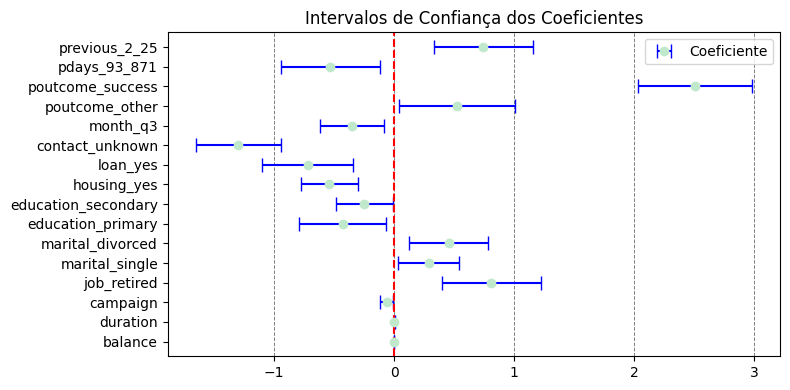

In [403]:
rl.plot_IC95(model= model_full)

In [415]:
# salvarndo o dataframe modelo final para modelagem em um novo arquivo CSV
df_modelo.to_csv('../data/bank_marketing_modelo_final.csv', sep=';', index=False)

In [595]:
model_full.params.index

Index(['Intercept', 'balance', 'duration', 'campaign', 'job_retired',
       'marital_single', 'marital_divorced', 'education_primary',
       'education_secondary', 'housing_yes', 'loan_yes', 'contact_unknown',
       'month_q3', 'poutcome_other', 'poutcome_success', 'pdays_93_871',
       'previous_2_25'],
      dtype='object')

### <code style='color:green'> Construindo o modelo baseado em seleção de variáveis step_wise com métrica aic </code>

In [596]:
var_independentes = ['balance', 'duration', 'campaign', 'job_retired',
       'marital_single', 'marital_divorced', 'education_primary',
       'education_secondary', 'housing_yes', 'loan_yes', 'contact_unknown',
       'month_q3', 'poutcome_other', 'poutcome_success', 'pdays_93_871',
       'previous_2_25']

In [597]:
# faz a seleção de variáveis pelo método forward baseado no p-valor
df_vars_modelo = rl.stepwise('subscribed', var_independentes, df_modelo, 'aic', 0.05)

In [605]:
df_vars_modelo['var']

0    [education_secondary, duration, poutcome_succe...
Name: var, dtype: object

In [611]:
formula_final = 'subscribed ~ education_secondary + duration + poutcome_success + contact_unknown + housing_yes + loan_yes + previous_2_25 + job_retired + month_q3 + campaign + pdays_93_871 + marital_divorced + marital_single + poutcome_other + education_primary'
model_step_fwd = smf.glm(formula=formula_final, data=df_modelo, family=sma.families.Binomial()).fit()
model_step_fwd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4505
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1139.2
Date:                sex, 09 jan 2026   Deviance:                       2278.3
Time:                        16:42:24   Pearson chi2:                 1.01e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1900
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.7864      0.161    -17.295      0.000      -3.102      -2.471
education_secondary    -0.2488      0.121     -2.055      0.040      -0.486      -0.012
duration                0.0040      0.000     20.763      0.000       0.004       0.004
poutcome_success        2.5087      0.243     10.335      0.000       2.033       2.984
contact_unknown        -1.2995      0.180     -7.201      0.000      -1.653      -0.946
housing_yes            -0.5378      0.121     -4.438      0.000      -0.775      -0.300
loan_yes               -0.7190      0.193     -3.735      0.000      -1.096      -0.342
previous_2_25           0.7433      0.210      3.542      0.000       0.332       1.155
job_retired             0.8104      0.209      3.880      0.000       0.401       1.220
month_q3               -0.3483      0.136     -2.570      0.010      -0.614      -0.083
campaign               -0.0610      0.027     -2.260      0.024      -0.114      -0.008
pdays_93_871           -0.5299      0.211     -2.509      0.012      -0.944      -0.116
marital_divorced        0.4571      0.167      2.734      0.006       0.129       0.785
marital_single          0.2876      0.128      2.244      0.025       0.036       0.539
poutcome_other          0.5262      0.246      2.139      0.032       0.044       1.008
education_primary      -0.4286      0.186     -2.303      0.021      -0.793      -0.064
=======================================================================================
"""

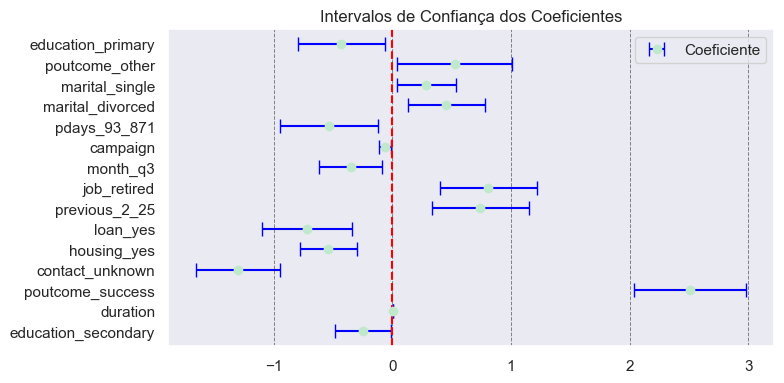

In [ ]:
rl.plot_IC95(model= model_step_fwd)

In [614]:
model_step_fwd.pvalues > 0.05

Intercept              False
education_secondary    False
duration               False
poutcome_success       False
contact_unknown        False
housing_yes            False
loan_yes               False
previous_2_25          False
job_retired            False
month_q3               False
campaign               False
pdays_93_871           False
marital_divorced       False
marital_single         False
poutcome_other         False
education_primary      False
dtype: bool

### <code style='color:green'> Vamos analisar e interpretar as Odds Ratios </code>

In [608]:
#Calculando a exponencial do parâmetro (Odds ratio)
np.exp(model_step_fwd.params)

Intercept               0.061640
education_secondary     0.779704
duration                1.004005
poutcome_success       12.289123
contact_unknown         0.272668
housing_yes             0.584022
loan_yes                0.487224
previous_2_25           2.102807
job_retired             2.248848
month_q3                0.705893
campaign                0.940780
pdays_93_871            0.588683
marital_divorced        1.579537
marital_single          1.333165
poutcome_other          1.692506
education_primary       0.651418
dtype: float64

In [609]:
# Gerando o valor exponencial dos coeficientes
(np.exp(model_step_fwd.params)-1)*100

Intercept               -93.836023
education_secondary     -22.029631
duration                  0.400514
poutcome_success       1128.912338
contact_unknown         -72.733153
housing_yes             -41.597774
loan_yes                -51.277612
previous_2_25           110.280667
job_retired             124.884775
month_q3                -29.410684
campaign                 -5.921959
pdays_93_871            -41.131674
marital_divorced         57.953687
marital_single           33.316545
poutcome_other           69.250590
education_primary       -34.858189
dtype: float64

### <code style='color:green'> Qual é a história que os dados nos contam? </code>
- Vamos interpretar as Odds Ratios:
    - OR - education_secondary x education_tertiary_unknown (casela) = 0.7797036889073811
        - Clientes com ensino secundário tem 22% menos chance de assinar um depósito a prazo do que clientes com ensino ensino superior ou desconhecido.

    - OR - education_primary x education_tertiary_unknown (casela) = 0.6514181122415893
        - Clientes com ensino primário tem 34,86% menos chance de assinar um depósito a prazo do que clientes com ensino ensino superior ou desconhecido.

    - OR - contact_unknown x contact_cellular_telephone (casela) = 0.27266847020287943
        - Clientes que foram contatados pelo tipo de comunicação desconhecido tem 72,73% menos chance de assinar um depósito a prazo do que clientes contatados através de celular ou telefone.

    - OR - housing_yes x housing_no (casela) = 0.5840222597141608
        - Clientes com empréstimo habitacional tem 41,60% menos chance de assinar um depósito a prazo do que clientes sem empréstimo habitacional.

    - OR - job_retired x job_management_others (casela) = 2.2488477542414387
        - Clientes aposentados tem 124,88% mais chance de assinar um depósito a prazo do que clientes com cargo de gerenciamento ou outros.

    - OR - loan_yes x loan_no (casela) = 0.48722388006950157
        - Clientes com empréstimo pessoal tem 51,28% menos chance de assinar um depósito a prazo do que clientes sem empréstimo pessoal.

    - OR - marital_divorced x marital_married (casela) = 1.5795368744675988
        - Clientes divorciados ou viuvos tem 57,95% mais chance de assinar um depósito a prazo do que clientes casados.

    - OR - marital_single x marital_married (casela) = 1.3331654524191003
        - Clientes solteiros tem 33,31% mais chance de assinar um depósito a prazo do que clientes casados.

    - OR - month_q3 x month_q1_q2_q4 (casela) = 0.705893162579188
        - Clientes cujo ultimo contato do ano foi no 3o. trimestre tem 29,41% menos chance de assinar um depósito a prazo do que clientes cujo ultimo contato do ano foi no 1o. ou 2o. ou 4o. trimestre.

    - OR - poutcome_success x poutcome_failure_unknown (casela) = 12.28912338426787
        - Clientes onde o resultado da campanha de marketing anterior foi um sucesso tem 1129% mais chance de assinar um depósito a prazo do que clientes onde o resultado da campanha foi um fracasso ou desconhecido.

    - OR - poutcome_other x poutcome_failure_unknown (casela) = 1.6925059038430348
        - Clientes onde o resultado da campanha de marketing anterior foi outro tem 69,25% mais chance de assinar um depósito a prazo do que clientes onde o resultado da campanha foi um fracasso ou desconhecido.

    - OR - previous_2_25 x previous_0_1 (casela) = 2.1028066726162624
        - Clientes que foram contatados entre 2 e 25 vezes em uma campanha anterior tem 110,28% mais chance de assinar um depósito a prazo do que clientes que não foram contatados ou foram contatados uma unica vez.

    - OR - pdays_93_871 x pdays_sem_contato_92 (casela) = 0.5886832555325398
        - Clientes no qual o número de dias que se passaram do ultimo contato em uma campanha anterior foi entre 93 e 871 dias, possuem 41,13% menos chance de assinar um depósito a prazo do que clientes que não foram contatados ou o número de dias transcorridos foi de até 92.

    - OR - campaign = 0.9407804066057027
        - Para cada aumento de uma unidade no número de contatos realizados durante essa campanha, a chance do cliente assinar um depósito a prazo diminuem 5,92%, mantendo constantes as demais variáveis.

    - OR - duration = 1.0040051366859082
        - Para cada aumento de uma unidade na duração do ultimo contato, em segundos, a chance do cliente assinar um depósito a prazo aumenta em 0,4%, mantendo constantes as demais variáveis.
        - o	Valor não significativo, pois o valor do OR está muito próximo de 1.


In [438]:
model_step_fwd.fittedvalues

0       0.124745
1       0.066469
2       0.101624
3       0.021207
4       0.039256
          ...   
4516    0.061971
4517    0.025204
4518    0.063681
4519    0.209970
4520    0.153224
Length: 4521, dtype: float64

In [616]:
# criando um dataframe para calcular as métricas de avaliação do modelo
df_metricas = pd.DataFrame()
df_metricas['subscribed'] = df_modelo['subscribed']
df_metricas['p_chapeu'] = model_step_fwd.fittedvalues
df_metricas.head()

,subscribed,p_chapeu
0,0,0.049251
1,0,0.036955
2,0,0.052742
3,0,0.008231
4,0,0.017459


### <code style="color:green">Calculando as métricas de qualidade de ajuste do nosso modelo. </code>


**Root Mean Squared Error (RMSE):** Quanto menor o valor, o modelo será mais preciso, mais correto e mais perto da verdade a "esperança" estatística vai estar.

**Precision:** De todo mundo que eu disse que é 1, quantos eu acertei.

\begin{align*}
\text{Precision} = \frac{\text{Verdadeiros Positivos (VP)}}{\text{Verdadeiros Positivos (VP)} + \text{Falsos Positivos (FP)}}
\end{align*}

**Recall:** De todo mundo que é realmente 1, quantos eu peguei.

\begin{align*}
\text{Recall} = \frac{\text{Verdadeiros Positivos (VP)}}{\text{Verdadeiros Positivos (VP)} + \text{Falsos Negativos (FN)}}
\end{align*}

**O Lift:** Mede o quanto é melhor que a seleção aleatória, conforme a ordenação. Ele comporta um conjunto de passos:

- Ordenar a base pela resposta do modelo em ordem decrescente.

- Dividir a base de 10 em 10%.

- Calcula a taxa de resposta para cada percentil ordenado.

- Calcular a média da base de dados geral.

- Calcular a razão entre a média de cada percentil sobre a média geral.

**Curva ROC:** Representa graficamente a relação entre a taxa de verdadeiros positivos (TPR ou sensibilidade/Recall) e a taxa de falsos positivos (FPR) para diferentes valores de limiar de decisão. Nas palavras que usamos no curso, estamos visualizando no eixo x os 0's de todos os 0's e no eixo y os 1's de todos os 1's.

**AUC:** Área debaixo da **Curva ROC**. Quanto maior, melhor o modelo.



In [617]:
# definindo o ponto de corte
ponto_corte = 0.5
df_metricas['subscribed_corte'] = np.where(df_metricas['p_chapeu'] >= ponto_corte, 1, 0)  
df_metricas.head()

,subscribed,p_chapeu,subscribed_corte
0,0,0.049251,0
1,0,0.036955,0
2,0,0.052742,0
3,0,0.008231,0
4,0,0.017459,0


In [447]:
target_names = ['Não assinou (0)', 'Assinou (1)']

In [618]:
# Relatorio de Classificação model_log_skb.best_estimator_
print('Relatório de Métricas de Avaliação'.center(65) + ('\n') + ('-' * 65))
print(classification_report(df_metricas['subscribed'], df_metricas['subscribed_corte'], digits=4, target_names=target_names) + ('\n') + ('-' * 15))
# Precision
precision = precision_score(df_metricas['subscribed'], df_metricas['subscribed_corte'])
print('Precision: {:.4f}\n'.format(precision))
# Recall
recall = recall_score(df_metricas['subscribed'], df_metricas['subscribed_corte'])
print('Recall: {:.4f}\n'.format(recall))
# AUC
print("AUC: {:.4f}\n".format(roc_auc_score(df_metricas['subscribed'], df_metricas['subscribed_corte'])))

                Relatório de Métricas de Avaliação               
-----------------------------------------------------------------
                 precision    recall  f1-score   support

Não assinou (0)     0.9154    0.9798    0.9465      4000
    Assinou (1)     0.6625    0.3052    0.4179       521

       accuracy                         0.9020      4521
      macro avg     0.7890    0.6425    0.6822      4521
   weighted avg     0.8863    0.9020    0.8856      4521

---------------
Precision: 0.6625

Recall: 0.3052

AUC: 0.6425



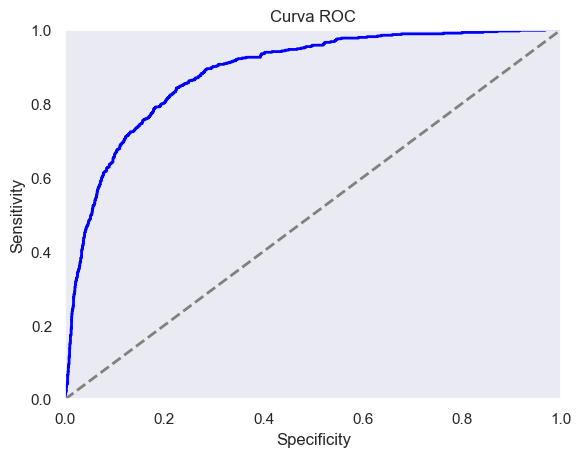

In [619]:
#Curva ROC
fpr, tpr, _ = roc_curve(df_metricas['subscribed'], df_metricas['p_chapeu'])
area_curva_roc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Linha de referência
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Curva ROC')
plt.show()

[Text(0, 0, 'Não assinou (0)'), Text(0, 1, 'Assinou (1)')]

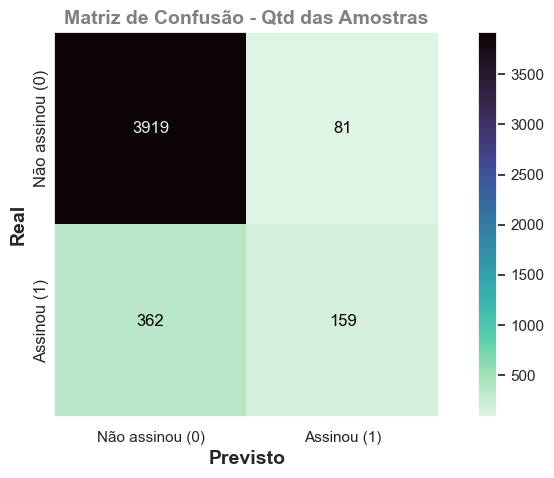

In [620]:
# Plotar Matriz de Confusão
sns.set_theme(style="dark")
labels = ['Não assinou (0)', 'Assinou (1)']
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ConfusionMatrixDisplay.from_predictions(df_metricas['subscribed'], df_metricas['subscribed_corte'], display_labels=labels, ax=ax, values_format='.0f', cmap='mako_r')
ax.set_xlabel('Previsto', fontsize=14, fontweight='bold')
ax.set_ylabel('Real', fontsize=14, fontweight='bold')
ax.set_title('Matriz de Confusão - Qtd das Amostras', fontsize=14, fontweight='bold', color='gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 90, ha="center", va='center', fontsize=12)

In [621]:
#matriz de confusão manualmente
matriz_conf = pd.crosstab(df_metricas['subscribed'], df_metricas['subscribed_corte'])
matriz_conf

subscribed_corte,0,1
subscribed,,
0,3919,81
1,362,159


In [622]:
# veja como funciona a soma da primeira linha (tudo que era 0 de verdade)
matriz_conf.iloc[0].sum()

np.int64(4000)

In [623]:
#Calculando a precisão
#Precision: de todos que estou dizendo que sao 1, quantos acertei

precision_05 = matriz_conf.iloc[1,1]/ matriz_conf.iloc[:,1].sum()
print("Precisão no corte 0.5:", precision_05)


Precisão no corte 0.5: 0.6625


In [624]:
#Calculando o recall
#Recall: de todos que sao 1, quantos estou pegando

recall_05 = matriz_conf.iloc[1,1]/ matriz_conf.iloc[1,:].sum()
print("Recall no corte 0.5:", recall_05)

Recall no corte 0.5: 0.30518234165067176


In [625]:
# calulando recall e precision de forma automática pela biblioteca
precision_05 = precision_score(df_metricas.subscribed, df_metricas.subscribed_corte)
print('Precisão no corte 0,5:', precision_05)
recall_05 = recall_score(df_metricas.subscribed, df_metricas.subscribed_corte)
print('Recall no corte 0,5:', recall_05)

Precisão no corte 0,5: 0.6625
Recall no corte 0,5: 0.30518234165067176


In [630]:
# calculando o MSE do modelo
df_metricas['MSE'] = (df_metricas['subscribed'] - df_metricas['p_chapeu'])**2
MSE_modelo = df_metricas['MSE'].mean()
print("MSE do modelo:", MSE_modelo)

MSE do modelo: 0.07407831864268762


In [631]:
#Calculando o RMSE
RMSE_modelo = np.sqrt(MSE_modelo)
print("RMSE do modelo:", RMSE_modelo)

RMSE do modelo: 0.2721733246346666


In [645]:
tabela_lift = rl.calcula_lift(target=df_metricas['subscribed'], p_chapeu=df_metricas['p_chapeu'])
tabela_lift

,taxa_resposta,lift,%
percentil,,,
1,0.560706,4.865554,386.555402
2,0.416575,3.614844,261.484396
3,0.324245,2.813647,181.364702
4,0.262576,2.278515,127.851466
5,0.217161,1.884420,88.442004
6,0.187247,1.624840,62.484038
7,0.162401,1.409244,40.924398
8,0.142660,1.237935,23.793538
9,0.127550,1.106819,10.681861


Text(0.5, 0.98, 'Lift por percentil')

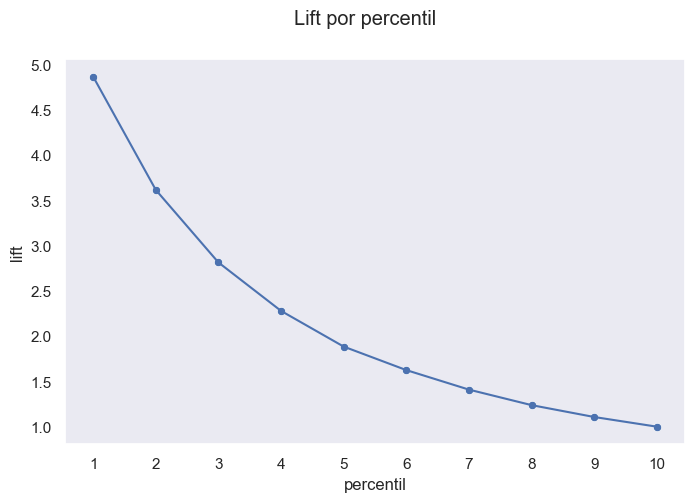

In [629]:
# criar um grafico percentil x lift
fig, ax = plt.subplots(1, 1, figsize=(8,5))
sns.scatterplot(data=tabela_lift, x='percentil', y='lift', palette='mako_r')
sns.lineplot(data=tabela_lift, x='percentil', y='lift', palette='mako_r')
fig.suptitle('Lift por percentil')

### <code style='color:green'> Vamos mostrar agora qual a qualidade do nosso modelo para objetivos diferentes: </code>
- Modelo com objetivo decisão
- Modelo tem objetivo ordenação
- Modelo tem objetivo estimação

<code style='color:gold'> Primeiro cenário - Objetivo Decisão </code>
> A empresa decidiu que probabilidades maiores que 0.5 (p_chapeu > 0.5) serão considerados como casos que o cliente assinou um depósito a prazo (1), caso contrário não assinou (0).

- O volume de clientes para esse cenário é de 240 clientes assinaram o depósito a prazo (1) e 4281 clientes não assinaram o depósito a prazo (0).

- Baseado no resultado da precisão de corte de 0.5, de todos os clientes que o modelo disse que vão assinar o depósito a prazo, o acerto foi de 66,25%, e de todos os clientes que realmente assinaram o depósito a prazo, o modelo teve exito de 30,52% no alcance.

<code style='color:gold'> Segundo cenário - Objetivo estimação </code>
> A empresa gostaria de saber, qual a esperança de valores de depositos a prazo receberia na próxima campanha?

- O volume de clientes para esse cenário é de 521 clientes assinaram o depósito a prazo (1) e 4000 clientes não assinaram o depósito a prazo (0).
- Vamos assumir que o valor médio dos depósitos a prazo seja de 775 euros.
- A esperança de valores de depósitos a prazo atráves do modelo seria de 403775.00 euros.

In [641]:
valor_verdadeiro = df_metricas['subscribed'].sum() * 775
print(f"Valor verdadeiro do total dos depósitos a prazo: {valor_verdadeiro:.2f} euros")

Valor verdadeiro do total dos depósitos a prazo: 403775.00 euros


In [642]:
# calcula a esperança de valor dos depósitos a prazo com base nas previsões do modelo
valor_esperado = df_metricas['p_chapeu'].sum() * 775
print(f"Valor total estimado dos depósitos a prazo: {valor_esperado:.2f} euros")

Valor total estimado dos depósitos a prazo: 403775.00 euros


<code style='color:gold'> Terceiro cenário - Objetivo ordenação </code>
> A empresa gostaria de atuar de uma forma mais ativa numa próxima campanha, nos 20% dos clientes com maior probabilidade de assinar um depósito a prazo.

- Restrição de negócio: capacidade de atuar em somente 20% dos clientes.
- Se a empresa não utilizar o modelo, terá que selecionar os clientes de forma aleatória e tera um retorno de 11,52%, ou seja, de todos os clientes abordados, somente 11,52% deles assinariam um depósito a prazo.
- Utilizando o modelo, dentro da restrição de 20% da operação, consegue-se trazer um retorno 261,48% maior do que não ter o modelo.


In [585]:
reload(eda)
eda_bank_marketing = eda.Eda_lib(dataframe=df_bank_marketing, nome="df_bank_marketing", colormap="mako_r" )

In [394]:
reload(eda)
eda_df_modelo = eda.Eda_lib(dataframe=df_modelo, nome="df_modelo", colormap="mako_r" )

In [643]:
reload(rl)

<module 'regressao_log_lib' from 'd:\\Repositorio\\DataScience\\Case\\bank_marketing\\bank_marketing\\regressao_log_lib.py'>

In [395]:
reload(ht)

<module 'hipoteses_lib' from 'd:\\Repositorio\\DataScience\\Case\\bank_marketing\\bank_marketing\\hipoteses_lib.py'>